In [1]:
import numpy as np
import pandas as pd
import random, copy, os
random.seed(42)
np.random.seed(42)
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from multiprocessing import Pool
import multiprocessing
%run helper.ipynb
%run algorithm_functions.ipynb

In [2]:
df = pd.read_csv('./data/tripData2013/trip_data_1_filtered.csv')
df.head()

,medallion,hack_license,pickup_datetime,dropoff_datetime,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,driver_race,driver_gender,requests_gender,requests_race,pickup_lat_bin,pickup_long_bin,dropoff_lat_bin,dropoff_long_bin
0,89D227B655E5C82AECF13C3F540D4CF4,BA96DE419E711691B9445D6A6307C170,2013-01-01 15:11:48,2013-01-01 15:18:10,382,1.0,-73.978165,40.757977,-73.989838,40.751171,black,m,f,white,7,20,7,19
1,0BD7C8F5BA12B88E0B67BED28BEA73D8,9FD8F69F0804BDB5549F40E9DA1BE472,2013-01-06 00:18:35,2013-01-06 00:22:54,259,1.5,-74.006683,40.731781,-73.994499,40.750660,black,m,f,white,6,19,7,19
2,0BD7C8F5BA12B88E0B67BED28BEA73D8,9FD8F69F0804BDB5549F40E9DA1BE472,2013-01-05 18:49:41,2013-01-05 18:54:23,282,1.1,-74.004707,40.737770,-74.009834,40.726002,black,m,f,white,6,19,6,19
3,DFD2202EE08F7A8DC9A57B02ACB81FE2,51EE87E3205C985EF8431D850C786310,2013-01-07 23:54:15,2013-01-07 23:58:20,244,0.7,-73.974602,40.759945,-73.984734,40.759388,black,m,m,white,7,20,7,19
4,DFD2202EE08F7A8DC9A57B02ACB81FE2,51EE87E3205C985EF8431D850C786310,2013-01-07 23:25:03,2013-01-07 23:34:24,560,2.1,-73.976250,40.748528,-74.002586,40.747868,black,m,m,white,6,20,6,19


In [3]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

In [4]:
s = MinMaxScaler() # scaling distances such that all values are [0,1]
df['trip_distance'] = s.fit_transform(df['trip_distance'].values.reshape(-1, 1))

In [5]:
min_latitude = min(np.min(df['pickup_latitude']), np.min(df['dropoff_latitude']))
max_latitude = max(np.max(df['pickup_latitude']), np.max(df['dropoff_latitude']))
min_longitude = min(np.min(df['pickup_longitude']), np.min(df['dropoff_longitude']))
max_longitude = max(np.max(df['pickup_longitude']), np.max(df['dropoff_longitude']))

In [6]:
min_longitude, max_longitude, min_latitude, max_latitude

(-74.98333000000002, -73.011703, 40.400002, 40.999813)

In [7]:
requests_features = ['pickup_lat_bin', 'pickup_long_bin', 'dropoff_lat_bin', 'dropoff_long_bin', 
                     'requests_gender', 'requests_race']
driver_features = ['driver_race', 'driver_gender', 'pickup_lat_bin', 'pickup_long_bin']

###### Total number of drivers and types of drivers

In [8]:
all_driver_types = df.groupby(driver_features)['driver_gender'].agg('count')
print ("Total number of drivers: {}, total driver types: {}".format(len(set(list(df['hack_license']))), 
                                                                    len(all_driver_types)))

Total number of drivers: 32092, total driver types: 716


###### Total number and types of requests

In [9]:
all_request_types = df.groupby(['pickup_lat_bin', 'pickup_long_bin', 'dropoff_lat_bin', 'dropoff_long_bin', 
            'requests_gender', 'requests_race'])['requests_gender'].agg('count')
print ("Total requests: {}, types of requests: {}, total rides: {}".format(all_request_types.sum(), 
                                                                           len(all_request_types),
                                                                           len(df)))

Total requests: 14486242, types of requests: 8676, total rides: 14486242


In [10]:
peak_hour = 19
peak_day = 31

In [11]:
peak_hour_entries = df[np.logical_and(df['pickup_datetime'].dt.hour == peak_hour, 
                                     df['pickup_datetime'].dt.day == peak_day)]
peak_hour_entries.head()

,medallion,hack_license,pickup_datetime,dropoff_datetime,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,driver_race,driver_gender,requests_gender,requests_race,pickup_lat_bin,pickup_long_bin,dropoff_lat_bin,dropoff_long_bin
7853828,6B53BBA9567F90BD8A4130FEE57F703A,A21EF85E38B13F676E69C40A0127654B,2013-01-31 19:21:00,2013-01-31 19:32:00,660,0.044,-74.004677,40.711876,-73.972374,40.742809,white,m,m,white,6,19,6,20
7873451,E565EF3C83240654D540CBAA0D7C96EE,4269094FA5A341993B6707B5E1200AAA,2013-01-31 19:20:55,2013-01-31 19:49:11,1694,0.059,-73.976387,40.748592,-73.965439,40.678673,black,m,f,white,6,20,5,20
7877649,79584E2DA4A76EA45C482EA2B1C1B220,3B1803457E6CD3936B2C32CB856AD272,2013-01-31 19:17:16,2013-01-31 19:26:00,523,0.012,-73.983322,40.750206,-73.971024,40.762066,black,m,m,white,7,20,7,20
7879766,171BF6AD2C32D927735A7A5ADB516512,6CB8F868A9A20D3FAB2B3307C841C00B,2013-01-31 19:54:32,2013-01-31 20:14:15,1183,0.110,-73.872978,40.774025,-73.975807,40.676292,black,m,m,white,7,22,5,20
7880711,FB30B64440B4A7B8DBA9903C7598AD90,A4897540F0711AE1BC2C76A348883100,2013-01-31 19:56:28,2013-01-31 20:06:14,586,0.011,-73.977638,40.758900,-73.990395,40.767120,black,m,m,black,7,20,7,19


In [12]:
len(peak_hour_entries)

35109

In [13]:
historical_data = df[df['pickup_datetime'].dt.day != peak_day]
print (len(historical_data))
historical_data.head()

13965626


,medallion,hack_license,pickup_datetime,dropoff_datetime,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,driver_race,driver_gender,requests_gender,requests_race,pickup_lat_bin,pickup_long_bin,dropoff_lat_bin,dropoff_long_bin
0,89D227B655E5C82AECF13C3F540D4CF4,BA96DE419E711691B9445D6A6307C170,2013-01-01 15:11:48,2013-01-01 15:18:10,382,0.010,-73.978165,40.757977,-73.989838,40.751171,black,m,f,white,7,20,7,19
1,0BD7C8F5BA12B88E0B67BED28BEA73D8,9FD8F69F0804BDB5549F40E9DA1BE472,2013-01-06 00:18:35,2013-01-06 00:22:54,259,0.015,-74.006683,40.731781,-73.994499,40.750660,black,m,f,white,6,19,7,19
2,0BD7C8F5BA12B88E0B67BED28BEA73D8,9FD8F69F0804BDB5549F40E9DA1BE472,2013-01-05 18:49:41,2013-01-05 18:54:23,282,0.011,-74.004707,40.737770,-74.009834,40.726002,black,m,f,white,6,19,6,19
3,DFD2202EE08F7A8DC9A57B02ACB81FE2,51EE87E3205C985EF8431D850C786310,2013-01-07 23:54:15,2013-01-07 23:58:20,244,0.007,-73.974602,40.759945,-73.984734,40.759388,black,m,m,white,7,20,7,19
4,DFD2202EE08F7A8DC9A57B02ACB81FE2,51EE87E3205C985EF8431D850C786310,2013-01-07 23:25:03,2013-01-07 23:34:24,560,0.021,-73.976250,40.748528,-74.002586,40.747868,black,m,m,white,6,20,6,19


## Get Peak Hour Driver and Requests

##### Number of drivers in peak hour

In [14]:
peak_hour_driver_types = list(peak_hour_entries.groupby(driver_features)['hack_license'].agg('count').index)
print ("Driver Types: {}, Total Drivers: {}".format(len(peak_hour_driver_types), 
                                                    len(set(list(peak_hour_entries['hack_license'])))))
# assert len(set(list(peak_hour_drivers.values))) == len(peak_hour_drivers)

Driver Types: 82, Total Drivers: 10814


###### Number of request types in the peak hour and number of requests

In [15]:
peak_hour_requests = list(peak_hour_entries.groupby(requests_features)['requests_gender'].agg('count').index)
print ("Request Types: {}, Total requests: {}".format(len(peak_hour_requests), 
                                                      len(peak_hour_entries)))

Request Types: 800, Total requests: 35109


###### Subsample drivers for peak hour: assign k (=2) drivers for each driver type

In [16]:
subsample_fraction = 0.5
k = 10
driver_quota = 2
random.seed(42)
sampled_peak_hour_drivers = random.sample(peak_hour_driver_types, 
    k=int(subsample_fraction * len(peak_hour_driver_types)))
print ("Chosen driver types: {}".format(len(sampled_peak_hour_drivers)))

drivers = [] # Equivalent to set U
for driver_type in sampled_peak_hour_drivers:
    mask = None
    bool_peak_entries_match = peak_hour_entries[driver_features] == driver_type
    for ft in driver_features:
        mask = bool_peak_entries_match[ft].values if mask is None else\
            np.logical_and(mask, bool_peak_entries_match[ft].values)
#     for ft in range(len(driver_features)):
#         mask = (peak_hour_entries[driver_features[ft]] == driver_type[ft]).values if mask is None else\
#             np.logical_and(mask, (peak_hour_entries[driver_features[ft]] == driver_type[ft]).values)

    sampled_ids = random.sample(list(peak_hour_entries[mask]['hack_license']), k=k \
                                if k is not None and k < np.count_nonzero(mask) else np.count_nonzero(mask))
    for d_id in sampled_ids:
        driver_instance = Driver(**dict(zip(driver_features, driver_type)), d_id=d_id, quota=driver_quota)
        if driver_instance not in drivers:
            drivers.append(driver_instance)

set_unique_ids(drivers)

print ("Total number of drivers: {}, Size of set U: {}".format(len(drivers), len(set(drivers))))

Chosen driver types: 41
Total number of drivers: 223, Size of set U: 223


###### Subsample requests for the peak hour: multiply arrival rate of requests by k from each request type

In [17]:
def count_total_requests(all_entries, sampled_request_types):
    total = 0
    for request_vals in sampled_request_types:
        mask = None
        bool_peak_entries_match = all_entries[requests_features] == request_vals
        for ft in requests_features:
            mask = np.array(bool_peak_entries_match[ft]) if mask is None else \
                mask & np.array(bool_peak_entries_match[ft])
        total += np.count_nonzero(mask)
    return total

In [18]:
subsample_fraction = 0.2
k = 1
random.seed(42)
sampled_request_types = random.sample(peak_hour_requests, k=int(subsample_fraction * len(peak_hour_requests)))
print ("Chosen types of requests: {}".format(len(sampled_request_types)))
total_sampled_requests = count_total_requests(peak_hour_entries, sampled_request_types)
if subsample_fraction == 1:
    assert total_sampled_requests == len(peak_hour_entries)
print ("Total Sampled Requests: {}".format(total_sampled_requests))

requests = [] # Equivalent to set V
for request_vals in sampled_request_types:
    mask = None
    bool_peak_entries_match = peak_hour_entries[requests_features] == request_vals
    for ft in requests_features:
        mask = np.array(bool_peak_entries_match[ft]) if mask is None else \
            mask & np.array(bool_peak_entries_match[ft])
    # Find average distance in miles and put that in request type
    requests.append(Request(**dict(zip(requests_features, request_vals)), 
                            arrival_rate=float(np.count_nonzero(mask)),
                            distance=np.mean(peak_hour_entries[mask]['trip_distance'])))

set_unique_ids(requests)

print ("Number of Requests: {}, size of set V: {}".format(
    np.sum([r.arrival_rate for r in requests]), len(set(requests))))

Chosen types of requests: 160
Total Sampled Requests: 5854
Number of Requests: 5854.0, size of set V: 160


In [19]:
def edge_existence_bool(driver, request):
    if driver.latitude == request.start_latitude and driver.longitude == request.start_longitude:
        return True
    else:
        return False

def draw_probability_edges(drivers, requests):
    edge_matrix = np.zeros((len(drivers), len(requests))) - 1
    for d in drivers:
        for r in requests:
            if edge_existence_bool(d, r):
                edge_matrix[d.u_id, r.u_id] = calculate_probability(r, d)
    return edge_matrix

In [20]:
def filter_out_requests(drivers, requests, total_requests):
    probability_matrix = draw_probability_edges(drivers, requests)
    new_requests, new_total = [], total_requests
    average_arrival_rate = total_requests/len(requests)
    
#     for r in requests:
#         if np.count_nonzero(probability_matrix[:,r.u_id] != -1) > 20 and r.arrival_rate >= average_arrival_rate:
#             if abs(r.arrival_rate - average_arrival_rate) > 10:
#                 new_arrival_rate = int(average_arrival_rate) + random.randint(0, 10)
#                 new_total -= (r.arrival_rate - new_arrival_rate)
#                 r.arrival_rate = new_arrival_rate
#             new_requests.append(r)
#         else:
#             new_total -= r.arrival_rate

    for i in range(len(requests)):
        if np.count_nonzero(probability_matrix[:,requests[i].u_id] != -1) > 5:
            new_requests.append(requests[i])
        else:
            new_total -= requests[i].arrival_rate
    np.random.seed(42)
    new_arrival_rates = np.random.normal(loc=average_arrival_rate, scale=10, size=len(new_requests))
    for i in range(len(new_requests)):
        new_total -= new_requests[i].arrival_rate
        new_requests[i].arrival_rate = round(new_arrival_rates[i])
        new_total += new_requests[i].arrival_rate
    assert int(new_total) == new_total
    return new_requests, int(new_total)

In [21]:
len(drivers), len(requests)

(223, 160)

### To ensure that all requests have an edge to a driver

In [22]:
requests, total_sampled_requests = filter_out_requests(drivers, requests, total_sampled_requests)
set_unique_ids(requests)

In [23]:
print ("Number of Requests: {} {}, size of set V: {}".format(
    np.sum([r.arrival_rate for r in requests]), total_sampled_requests, len(set(requests))))

Number of Requests: 5189.0 5189, size of set V: 145


### Construct a matrix containing the edges, matrix = drivers x requests

In [24]:
probability_matrix = draw_probability_edges(drivers, requests)

In [25]:
print (np.min(probability_matrix[probability_matrix != -1]), 
       np.max(probability_matrix[probability_matrix != -1]), 
       np.mean(probability_matrix[probability_matrix != -1]))
for col in range(probability_matrix.shape[1]):
    if np.all(probability_matrix[:,col] == -1):
        print (requests[col])

0.55 0.8 0.6425918108906711


In [26]:
profit_matrix = np.zeros(probability_matrix.shape)
for i,j in zip(*np.where(probability_matrix != -1)):
    profit_matrix[i,j] = requests[j].distance
profit_matrix 

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [27]:
edge_traversal_counts = np.zeros(probability_matrix.shape) # same as x_f in the paper    

In [28]:
(np.count_nonzero(probability_matrix != -1), np.count_nonzero(profit_matrix), 
probability_matrix.shape[0] * probability_matrix.shape[1])

(2369, 2369, 32335)

## In-degrees of drivers and riders

In [29]:
r_vs = []
for r in requests:
    r_vs.append(r.arrival_rate)
min(r_vs), max(r_vs)

in_degree_v = []
for i in range(len(requests)):
    in_degree_v.append(np.count_nonzero(probability_matrix[:,i] != -1))

in_degree_u = []
for i in range(len(drivers)):
    in_degree_u.append(np.count_nonzero(probability_matrix[i,:] != -1))

print ("Drivers' in-degree, average: {}, min: {}, max: {}\nRiders' in-degree, average: {}, min: {}, max: {}"\
       .format(np.mean(in_degree_u), min(in_degree_u), max(in_degree_u), 
               np.mean(in_degree_v), min(in_degree_v), max(in_degree_v)))

Drivers' in-degree, average: 10.623318385650224, min: 0, max: 20
Riders' in-degree, average: 16.337931034482757, min: 8, max: 29


### We have all variables now, use them to solve the LP

In [30]:
from cvxopt.base import matrix as m
from cvxopt import solvers
from cvxopt.modeling import op, dot, variable, max, min

### Profit Objective

In [31]:
x_f = variable(np.count_nonzero(probability_matrix != -1))
c = []
for i, j in zip(*np.where(probability_matrix != -1)):
    c.append(-1 * profit_matrix[i,j] * probability_matrix[i,j]) # multiply by -1 since we want to maximise w_f * x_f * p_f but cvxopt minimizes the objective function by default, since minimizing -obj is same as maximizing obj, we multiply our profit objective by a minus sign
assert len(c) == len(x_f)
c = m(c)
profit = dot(c, x_f)
c, x_f

(<2369x1 matrix, tc='d'>, variable(2369,''))

### Fairness Objective

In [32]:
x_fair = variable(np.count_nonzero(probability_matrix != -1))
fairness = get_fairness_objective(x_fair, probability_matrix, requests)

### Get LP constraints

In [33]:
inequality = get_inequalities(x_f, probability_matrix, requests)

2960 2960 2369 2369
<class 'cvxopt.modeling._function'>


In [34]:
lp_profit = op(profit, inequality)
lp_profit.solve(solver='mosek')

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : LO (linear optimization problem)
  Constraints            : 2960            
  Cones                  : 0               
  Scalar variables       : 2369            
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.01    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : LO (linear optimization problem)
  Constraints            : 2960            
  Cones                  :

In [35]:
max(x_f.value), min(x_f.value)

(1.8181818181818181, 0.0)

In [36]:
inequality_fairness = get_inequalities(x_fair, probability_matrix, requests)

2960 2960 2369 2369
<class 'cvxopt.modeling._function'>


In [37]:
lp_fairness = op(fairness, inequality_fairness)
lp_fairness.solve(solver='mosek')

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : LO (linear optimization problem)
  Constraints            : 3105            
  Cones                  : 0               
  Scalar variables       : 2370            
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.01    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : LO (linear optimization 

In [38]:
r_vs = []
for r in requests:
    r_vs.append(r.arrival_rate)
min(r_vs)

10.0

In [39]:
# Since we multiplied our objective by -1 and then minimized it
optimal_profit = -1 * lp_profit.objective.value()[0]
optimal_fairness = -1 * lp_fairness.objective.value()[0]
print ("When optimizing for fairness, fairness: {}, profit: {}".format(optimal_fairness, 
                                                                      -1 * dot(c, x_fair).value()[0]))
print ("When optimizing for profit, fairness: {}, profit: {}".format(
    -1 * get_fairness_objective(x_f, probability_matrix, requests).value()[0], optimal_profit))

When optimizing for fairness, fairness: 0.01587301587301587, profit: 10.625949915405485
When optimizing for profit, fairness: -0.0, profit: 37.82249083333333


In [40]:
lp_solution_sanity_check(x_f, x_fair, probability_matrix, requests)

In [41]:
print (min(x_fair.value), max(x_fair.value))
number_probes = np.zeros(probability_matrix.shape)
for i in range(len(x_fair)):
    number_probes[index_to_coordinate(i, probability_matrix)] += x_fair.value[i]
expected_probes_optimal = np.sum(number_probes, axis=0)
# for i in range(len(requests)):
#     expected_probes_optimal[i] /= requests[i].arrival_rate
print (expected_probes_optimal)

0.0 1.8181818181818181
[0.83333333 0.69444444 1.25       1.5007215  0.98124098 1.23015873
 1.03174603 2.1001221  0.63492063 1.0515873  1.81818182 0.63492063
 1.12554113 0.33730161 1.81818182 0.89466089 0.75036075 0.79365079
 1.53846154 0.43650794 1.81818182 0.83028083 0.73412698 0.63492063
 0.89466089 1.47186147 0.77922078 1.53846154 0.89466089 0.83028083
 0.75702076 1.81818182 1.03896104 0.75036075 1.81818182 1.53846154
 1.81818182 0.60606061 1.53846154 1.12554113 2.14466089 0.75396825
 0.85470085 0.83028083 0.53724054 0.57539683 0.63492063 1.35642136
 0.91269839 0.37698413 1.25       0.6547619  0.73260073 0.8531746
 1.81818182 2.1001221  1.81818182 0.6547619  0.79365079 1.32756133
 0.81349206 0.69444444 0.51587302 0.49603175 1.2987013  0.99206349
 1.81818182 1.35642136 1.66666667 0.86580087 1.25       2.85714286
 1.53846154 1.53846154 0.28860029 1.53846154 1.25       0.98124098
 1.0966811  0.41514042 0.67460317 1.74603175 1.24542125 0.61507937
 0.70818071 0.78144078 1.93181818 0.9768

### From this point on x_f is x* and x_fair is y*

In [43]:
drivers_copy = [copy.deepcopy(d) for d in drivers] # to avoid overwriting driver values here

all_requests = []
for r in requests:
    all_requests += [r] * int(r.arrival_rate)
random.shuffle(all_requests)

# This isn't exactly correct since we need to look at "expected fairness"
exact_profit, exact_count, exact_matches = run_algorithm(all_requests, drivers_copy, 
                                                         probability_matrix, x_f, x_fair)
exact_fairness = measure_exact_fairness(all_requests, exact_matches)

print (exact_profit, optimal_profit, exact_count, len(all_requests))
print ("Competetive Ratio (Profit): {}, Theoretical lower bound: {}".format(
    exact_profit/optimal_profit, 0.5/np.e))
print ("Competetive Ratio (Fairness): {}, Theoretical lower bound: {}".format(
    exact_fairness/optimal_fairness, 0.5/np.e))

18.036406962542507 37.82249083333333 202 5189
Competetive Ratio (Profit): 0.4768698878670054, Theoretical lower bound: 0.18393972058572117
Competetive Ratio (Fairness): 1.1454545454545457, Theoretical lower bound: 0.18393972058572117


In [44]:
alphas, betas = np.arange(0.,1.01,0.1), np.arange(0.,1.01,0.1)
num_loops = 5000

### Just for testing: alpha = 0.5, beta=0.5, if confident, go straight to "Over all params"

In [ ]:
test_algorithm_params = []
for i in range(int(num_loops/100)):
    random.shuffle(all_requests)
    test_algorithm_params.append([all_requests, [copy.deepcopy(d) for d in drivers]])

with Pool(multiprocessing.cpu_count()) as p:
    test_matching_results = p.starmap(run_algorithm, test_algorithm_params)

In [ ]:
test_fairness_measure_params = []
for i in range(int(num_loops/100)):
    test_fairness_measure_params.append([test_algorithm_params[i][0], test_matching_results[i][2]])

with Pool(multiprocessing.cpu_count()) as p:
    test_edges_count_results = p.starmap(measure_fairness_edges_count, test_fairness_measure_params)

In [ ]:
test_expected_profit = 0
for i in range(int(num_loops/100)):
    test_expected_profit += test_matching_results[i][0]
print (test_expected_profit/10)
print (optimal_profit)

In [1042]:
expected_probes_nadap = np.mean(np.array(test_edges_count_results), axis=0)
for i in range(len(requests)):
    expected_probes_nadap[i] /= requests[i].arrival_rate
print (min(expected_probes_nadap)/optimal_fairness)
# for i in range(len(requests)):
#     print (min(probability_matrix[:,i][probability_matrix[:,i] != -1]))
#     print (max(probability_matrix[:,i][probability_matrix[:,i] != -1]))

0.0


## Over all params

In [45]:
algorithm_params = []
for alpha in alphas:
    for i in range(num_loops):
        algorithm_params.append([all_requests, [copy.deepcopy(d) for d in drivers], 
                                 probability_matrix, x_f, x_fair, alpha, 1-alpha])

In [ ]:
with Pool(multiprocessing.cpu_count()) as p:
    matching_results = p.starmap(run_algorithm, algorithm_params)

assert len(matching_results) == num_loops * len(alphas)

In [ ]:
fairness_measure_params = []
for i in range(len(alphas)):
    for j in range(num_loops):
        fairness_measure_params.append([all_requests, matching_results[i * num_loops + j][2], requests])

In [ ]:
with Pool(multiprocessing.cpu_count()) as p:
    edges_count_results = p.starmap(measure_fairness_edges_count, fairness_measure_params)

In [54]:
profit_crs, fairness_crs = [], []
for j in range(len(alphas)):
    expected_profit = 0
    for i in range(num_loops):
        expected_profit += matching_results[j * num_loops + i][0]
    expected_profit /= num_loops
    profit_crs.append(expected_profit/optimal_profit)
    
    fairness_measure = calculate_fairness_from_array(edges_count_results[j*num_loops:(j+1)*num_loops], 
                                                     num_loops, requests)
    print (expected_profit/optimal_profit, fairness_measure/optimal_fairness)
    fairness_crs.append(fairness_measure/optimal_fairness)

0.4492996171199428 0.03672000000000001
0.4488952530314494 0.022680000000000006
0.4477397764879236 0.022680000000000006
0.4483767999952702 0.022680000000000006
0.4483645192501508 0.011340000000000003
0.44995393717247323 0.003780000000000001
0.44810991640054426 0.020160000000000008
0.44899331358146705 0.017640000000000003
0.44828115853216866 0.03654000000000001
0.44849155977567073 0.003780000000000001
0.4479073812294328 0.011340000000000003


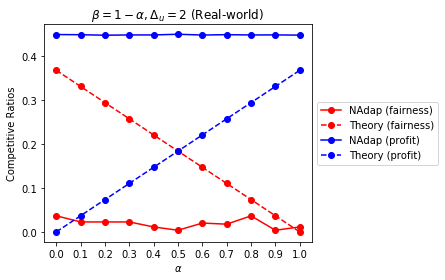

In [55]:
plot_lines([fairness_crs, [x/np.e for x in 1-alphas], profit_crs, [x/np.e for x in alphas]], 
            ["{:.1f}".format(x) for x in alphas], alphas, 
           r'$\beta = 1 - \alpha, \Delta_u = {}$ (Real-world)'.format(driver_quota), 
           r'$\alpha$', 'Competitive Ratios', ['-', '--', '-', '--'], ['red', 'red', 'blue', 'blue'], 
            ['NAdap (fairness)', 'Theory (fairness)', 'NAdap (profit)', 'Theory (profit)'], 
            'plots', 'profit_fairness_crs_vs_alpha_quota_2')

## Uniform and Greedy algorithms

In [ ]:
uniform_params, greedy_params = [], []
for i in range(num_loops):
    drivers_copy = [copy.deepcopy(d) for d in drivers]
    uniform_params.append([all_requests, drivers_copy, probability_matrix])
for i in range(num_loops):
    drivers_copy = [copy.deepcopy(d) for d in drivers]
    greedy_params.append([all_requests, drivers_copy, probability_matrix])

In [ ]:
with Pool(multiprocessing.cpu_count()) as p:
    uniform_results = p.starmap(run_uniform, uniform_params)

In [ ]:
with Pool(multiprocessing.cpu_count()) as p:
    greedy_results = p.starmap(run_greedy, uniform_params)

In [54]:
greedy_profit = 0
for res in greedy_results:
    greedy_profit += res[1]
greedy_profit /= num_loops
greedy_profit_cr = greedy_profit/optimal_profit
greedy_profit_cr

0.6559262703442464

In [ ]:
greedy_fairness_measure_params = []
for i in range(num_loops):
    greedy_fairness_measure_params.append([all_requests, greedy_results[i][0], requests])

with Pool(multiprocessing.cpu_count()) as p:
    greedy_edges_count_results = p.starmap(measure_fairness_edges_count, greedy_fairness_measure_params)

In [55]:
greedy_fairness_cr = calculate_fairness_from_array(greedy_edges_count_results, 
                                                   num_loops, requests)/optimal_fairness
greedy_fairness_cr

0.22044795783926227

In [56]:
uniform_profit = 0
for res in uniform_results:
    uniform_profit += res[1]
uniform_profit /= num_loops
uniform_profit_cr = uniform_profit/optimal_profit
uniform_profit_cr

0.5749549042059208

In [ ]:
uniform_fairness_measure_params = []
for i in range(num_loops):
    uniform_fairness_measure_params.append([all_requests, uniform_results[i][0], requests])

with Pool(multiprocessing.cpu_count()) as p:
    uniform_edges_count_results = p.starmap(measure_fairness_edges_count, uniform_fairness_measure_params)

In [57]:
uniform_fairness_cr = calculate_fairness_from_array(uniform_edges_count_results, 
                                                    num_loops, requests)/optimal_fairness
uniform_fairness_cr

0.397805642633229

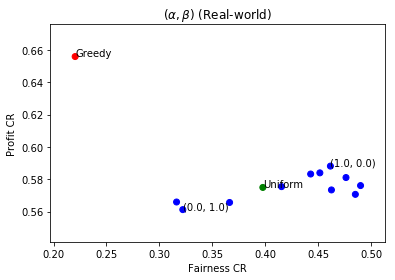

In [58]:
x_vals = fairness_crs + [uniform_fairness_cr, greedy_fairness_cr]
y_vals = profit_crs + [uniform_profit_cr, greedy_profit_cr]
annotations = ['({:.1f}, {:.1f})'.format(alpha, 1-alpha) if alpha == 0.0 or alpha == 1.0 else '' for alpha in alphas] + ['Uniform', 'Greedy']
colors = ['blue'] * len(fairness_crs) + ['green', 'red']
plot_scatter(x_vals, y_vals, colors, annotations, 
             r'$(\alpha, \beta), \Delta_u = {}$ (Real-world)'.format(driver_quota), 
             'Fairness CR', 'Profit CR', 'plots', 'fairness_vs_profit_cr_scatter_quota_2')

### For all other alpha, beta where alpha + beta < 1

In [ ]:
remaining_algorithm_params = []
coordinate_to_offset = {}
offset = 0
for alpha_i in range(len(alphas)):
    for beta_j in range(len(betas)):
        if alphas[alpha_i] + betas[beta_j] <= 1:
            coordinate_to_offset[(alpha_i, beta_j)] = offset
            offset += 1
            for i in range(num_loops):
                remaining_algorithm_params.append([all_requests, [copy.deepcopy(d) for d in drivers],
                                                   probability_matrix, x_f, x_fair, 
                                                   alphas[alpha_i], betas[beta_j]])

In [ ]:
with Pool(multiprocessing.cpu_count()) as p:
    remaining_matching_results = p.starmap(run_algorithm, remaining_algorithm_params)

In [ ]:
remaining_fairness_measure_params = []
for alpha_i in range(len(alphas)):
    for beta_j in range(len(betas)):
        if alphas[alpha_i] + betas[beta_j] <= 1:
            for i in range(num_loops):
                remaining_fairness_measure_params.append([all_requests, 
                            remaining_matching_results[coordinate_to_offset[(alpha_i, beta_j)]][2], requests])

In [ ]:
with Pool(multiprocessing.cpu_count()) as p:
    remaining_edges_count_results = p.starmap(measure_fairness_edges_count, remaining_fairness_measure_params)

In [331]:
for result in remaining_matching_results:
    if result[0] > 0:
        print (remaining_matching_resultsults.index(result))
        print (np.count_nonzero(result[2] != None))

500
1
501
1
502
1
503
1
504
1
505
1
506
1
507
1
508
1
509
1
510
1
511
1
512
1
513
1
514
1
515
1
516
1
517
1
518
1
519
1
520
1
521
1
522
1
523
1
524
1
525
1
526
1
527
1
528
1
529
1
530
1
531
1
532
1
533
1
534
1
535
1
536
1
537
1
538
1
539
1
540
1
541
1
542
1
543
1
544
1
545
1
546
1
547
1
548
1
549
1
550
1
551
1
552
1
553
1
554
1
555
1
556
1
557
1
558
1
559
1
560
1
561
1
562
1
563
1
564
1
565
1
566
1
567
1
568
1
569
1
570
1
571
1
572
1
573
1
574
1
575
1
576
1
577
1
578
1
579
1
580
1
581
1
582
1
583
1
584
1
585
1
586
1
587
1
588
1
589
1
590
1
591
1
592
1
593
1
594
1
595
1
596
1
597
1
598
1
599
1
600
1
601
1
602
1
603
1
604
1
605
1
606
1
607
1
608
1
609
1
610
1
611
1
612
1
613
1
614
1
615
1
616
1
617
1
618
1
619
1
620
1
621
1
622
1
623
1
624
1
625
1
626
1
627
1
628
1
629
1
630
1
631
1
632
1
633
1
634
1
635
1
636
1
637
1
638
1
639
1
640
1
641
1
642
1
643
1
644
1
645
1
646
1
647
1
648
1
649
1
650
1
651
1
652
1
653
1
654
1
655
1
656
1
657
1
658
1
659
1
660
1
661
1
662
1
663
1
664
1
665
1
666


1715
1
1716
1
1717
1
1718
1
1719
1
1548
1
1549
1
1550
1
1551
1
1552
1
1553
1
1554
1
1555
1
1556
1
1557
1
1558
1
1559
1
1560
1
1561
1
1562
1
1563
1
1564
1
1565
1
1566
1
1567
1
1568
1
1569
1
1570
1
1571
1
1572
1
1573
1
1574
1
1575
1
1576
1
1577
1
1578
1
1579
1
1580
1
1581
1
1582
1
1583
1
1584
1
1585
1
1586
1
1587
1
1588
1
1589
1
1590
1
1591
1
1592
1
1593
1
1594
1
1595
1
1596
1
1597
1
1598
1
1599
1
1600
1
1601
1
1602
1
1603
1
1604
1
1605
1
1606
1
1607
1
1608
1
1609
1
1610
1
1611
1
1612
1
1613
1
1614
1
1615
1
1616
1
1617
1
1618
1
1619
1
1620
1
1621
1
1622
1
1623
1
1624
1
1625
1
1626
1
1627
1
1628
1
1629
1
1630
1
1631
1
1632
1
1633
1
1634
1
1635
1
1636
1
1637
1
1638
1
1639
1
1640
1
1641
1
1642
1
1643
1
1644
1
1645
1
1646
1
1647
1
1648
1
1649
1
1650
1
1651
1
1652
1
1653
1
1654
1
1655
1
2000
1
2001
1
2002
1
2003
1
2004
1
2005
1
2006
1
2007
1
2008
1
2009
1
2010
1
2011
1
2012
1
2013
1
2014
1
2015
1
2016
1
2017
1
2018
1
2019
1
2020
1
2021
1
2022
1
2023
1
2024
1
2025
1
2026
1
2027
1
2028
1
2029
1

3064
1
3065
1
3066
1
3067
1
3068
1
3069
1
3070
1
3071
1
3072
1
3073
1
3074
1
3075
1
3076
1
3077
1
3078
1
3079
1
3080
1
3081
1
3082
1
3083
1
3084
1
3085
1
3086
1
3087
1
3088
1
3089
1
3090
1
3091
1
3092
1
3093
1
3094
1
3095
1
3263
1
3264
1
3265
1
3266
1
3267
1
3096
1
3097
1
3098
1
3099
1
3100
1
3101
1
3102
1
3103
1
3104
1
3105
1
3106
1
3107
1
3108
1
3109
1
3110
1
3111
1
3112
1
3113
1
3114
1
3115
1
3116
1
3117
1
3118
1
3119
1
3120
1
3121
1
3122
1
3123
1
3124
1
3125
1
3126
1
3127
1
3128
1
3129
1
3130
1
3131
1
3132
1
3133
1
3134
1
3135
1
3136
1
3137
1
3138
1
3139
1
3140
1
3141
1
3142
1
3143
1
3144
1
3145
1
3146
1
3147
1
3148
1
3149
1
3150
1
3151
1
3152
1
3153
1
3154
1
3155
1
3156
1
3157
1
3158
1
3159
1
3160
1
3161
1
3162
1
3163
1
3164
1
3165
1
3166
1
3167
1
3168
1
3169
1
3170
1
3171
1
3172
1
3173
1
3174
1
3175
1
3176
1
3177
1
3178
1
3179
1
3180
1
3181
1
3182
1
3183
1
3184
1
3185
1
3186
1
3187
1
3188
1
3189
1
3190
1
3191
1
3192
1
3193
1
3194
1
3028
1
3029
1
3030
1
3031
1
3032
1
3033
1
3034
1

4274
1
4275
1
4276
1
4277
1
4278
1
4279
1
4280
1
4281
1
4282
1
4283
1
4284
1
4285
1
4286
1
4287
1
4288
1
4289
1
4290
1
4291
1
4292
1
4293
1
4294
1
4295
1
4296
1
4297
1
4298
1
4299
1
4128
1
4129
1
4130
1
4131
1
4132
1
4133
1
4134
1
4135
1
4136
1
4137
1
4138
1
4139
1
4140
1
4141
1
4142
1
4143
1
4144
1
4145
1
4146
1
4147
1
4148
1
4149
1
4150
1
4151
1
4152
1
4153
1
4154
1
4155
1
4500
1
4501
1
4502
1
4503
1
4504
1
4505
1
4506
1
4507
1
4508
1
4509
1
4510
1
4511
1
4512
1
4513
1
4514
1
4515
1
4516
1
4517
1
4518
1
4519
1
4520
1
4521
1
4522
1
4523
1
4524
1
4525
1
4526
1
4527
1
4528
1
4529
1
4530
1
4531
1
4532
1
4533
1
4534
1
4535
1
4536
1
4537
1
4538
1
4539
1
4540
1
4541
1
4542
1
4543
1
4544
1
4545
1
4546
1
4547
1
4548
1
4549
1
4550
1
4551
1
4552
1
4553
1
4554
1
4555
1
4556
1
4557
1
4558
1
4559
1
4560
1
4561
1
4562
1
4563
1
4564
1
4565
1
4566
1
4567
1
4568
1
4569
1
4570
1
4571
1
4572
1
4573
1
4574
1
4575
1
4576
1
4577
1
4578
1
4579
1
4580
1
4581
1
4582
1
4583
1
4584
1
4585
1
4586
1
4587
1
4588
1

5587
1
5588
1
5589
1
5590
1
5591
1
5592
1
5593
1
5594
1
5595
1
5596
1
5597
1
5598
1
5599
1
5600
1
5601
1
5602
1
5603
1
5604
1
5605
1
5606
1
5607
1
5608
1
5609
1
5610
1
5611
1
5612
1
5613
1
5614
1
5615
1
5616
1
5617
1
5618
1
5619
1
5620
1
5621
1
5622
1
5623
1
5624
1
5625
1
5626
1
5627
1
5628
1
5629
1
5630
1
5631
1
5632
1
5633
1
5634
1
5635
1
5636
1
5637
1
5638
1
5639
1
5640
1
5641
1
5642
1
5643
1
5644
1
5645
1
5646
1
5647
1
5648
1
5649
1
5650
1
5651
1
5652
1
5653
1
5654
1
5655
1
5656
1
5657
1
5658
1
5659
1
5660
1
5661
1
5662
1
5663
1
5664
1
5665
1
5666
1
5667
1
5668
1
5669
1
5670
1
5671
1
5672
1
5673
1
5674
1
5675
1
5504
1
5505
1
5506
1
5507
1
5508
1
5509
1
5510
1
5511
1
5512
1
5513
1
5514
1
5515
1
5516
1
5517
1
5518
1
5519
1
5520
1
5521
1
5522
1
5523
1
5524
1
5525
1
5526
1
5527
1
5528
1
5529
1
5530
1
5531
1
5532
1
5533
1
5534
1
5535
1
5536
1
5537
1
5538
1
5539
1
5540
1
5541
1
5542
1
5543
1
5544
1
5545
1
5546
1
5547
1
5548
1
5549
1
5550
1
5551
1
5552
1
5553
1
5554
1
5555
1
5556
1
5557
1

7078
1
7079
1
7080
1
7081
1
7082
1
7083
1
7084
1
7085
1
7086
1
7087
1
7088
1
7089
1
7090
1
7091
1
7092
1
7093
1
7094
1
7095
1
7096
1
7097
1
7098
1
7099
1
7100
1
7101
1
7102
1
7103
1
7104
1
7105
1
7106
1
7107
1
7108
1
7109
1
7110
1
7111
1
7112
1
7113
1
7114
1
7115
1
7116
1
7117
1
7118
1
7119
1
7120
1
7121
1
7122
1
7123
1
7124
1
7125
1
7126
1
7127
1
7128
1
7129
1
7130
1
7131
1
7132
1
7133
1
7134
1
7135
1
7136
1
7137
1
7138
1
7139
1
7140
1
7141
1
7142
1
7143
1
7144
1
7145
1
7146
1
7147
1
7148
1
7149
1
7150
1
7151
1
7152
1
7153
1
7154
1
7155
1
7156
1
7157
1
7158
1
7159
1
7160
1
7161
1
7162
1
7163
1
7164
1
7165
1
7166
1
7167
1
7168
1
7169
1
7170
1
7171
1
7172
1
7173
1
7174
1
7175
1
7176
1
7177
1
7178
1
7179
1
7180
1
7181
1
7182
1
7183
1
7184
1
7185
1
7186
1
7187
1
7188
1
7189
1
7190
1
7191
1
7192
1
7193
1
7194
1
7195
1
7196
1
7197
1
7198
1
7199
1
7200
1
7201
1
7202
1
7203
1
7204
1
7205
1
7206
1
7207
1
7208
1
7209
1
7210
1
7211
1
7212
1
7213
1
7214
1
7215
1
7216
1
7217
1
7218
1
7219
1
7220
1

8254
1
8255
1
8256
1
8257
1
8258
1
8259
1
8260
1
8261
1
8262
1
8263
1
8264
1
8265
1
8266
1
8267
1
8268
1
8269
1
8270
1
8271
1
8272
1
8273
1
8274
1
8275
1
8276
1
8277
1
8278
1
8279
1
8280
1
8281
1
8282
1
8283
1
8284
1
8285
1
8286
1
8287
1
8288
1
8289
1
8290
1
8291
1
8292
1
8293
1
8294
1
8295
1
8296
1
8297
1
8298
1
8299
1
8300
1
8301
1
8302
1
8303
1
8304
1
8305
1
8306
1
8307
1
8308
1
8309
1
8310
1
8311
1
8312
1
8313
1
8314
1
8315
1
8316
1
8317
1
8318
1
8319
1
8320
1
8321
1
8322
1
8323
1
8324
1
8325
1
8326
1
8327
1
8328
1
8329
1
8330
1
8331
1
8332
1
8333
1
8334
1
8335
1
8336
1
8337
1
8338
1
8339
1
8340
1
8341
1
8342
1
8343
1
8344
1
8345
1
8346
1
8347
1
8348
1
8349
1
8350
1
8351
1
8352
1
8353
1
8354
1
8355
1
8356
1
8357
1
8358
1
8359
1
8360
1
8361
1
8362
1
8363
1
8364
1
8365
1
8366
1
8367
1
8368
1
8369
1
8370
1
8371
1
8372
1
8373
1
8374
1
8375
1
8376
1
8377
1
8378
1
8379
1
8380
1
8381
1
8382
1
8383
1
8384
1
8385
1
8386
1
8387
1
8388
1
8389
1
8390
1
8391
1
8392
1
8393
1
8394
1
8395
1
8396
1

9549
1
9550
1
9551
1
9552
1
9553
1
9554
1
9555
1
9556
1
9557
1
9558
1
9559
1
9560
1
9561
1
9562
1
9563
1
9564
1
9565
1
9566
1
9567
1
9568
1
9569
1
9570
1
9571
1
9572
1
9573
1
9574
1
9575
1
9576
1
9577
1
9578
1
9579
1
9580
1
9581
1
9582
1
9583
1
9584
1
9585
1
9586
1
9587
1
9588
1
9589
1
9590
1
9591
1
9592
1
9593
1
9594
1
9595
1
9596
1
9597
1
9598
1
9599
1
9600
1
9601
1
9602
1
9603
1
9604
1
9605
1
9606
1
9607
1
9608
1
9609
1
9610
1
9611
1
9612
1
9613
1
9614
1
9615
1
9616
1
9617
1
9618
1
9619
1
9620
1
9621
1
9622
1
9623
1
9624
1
9625
1
9626
1
9627
1
9628
1
9629
1
9630
1
9631
1
9632
1
9633
1
9634
1
9635
1
9636
1
9637
1
9638
1
9639
1
9640
1
9641
1
9642
1
9643
1
9644
1
9645
1
9646
1
9647
1
9648
1
9649
1
9650
1
9651
1
9652
1
9653
1
9654
1
9655
1
9656
1
9657
1
9658
1
9659
1
9660
1
9661
1
9662
1
9663
1
9664
1
9665
1
9666
1
9667
1
9668
1
9669
1
9670
1
9671
1
9672
1
9673
1
9674
1
9675
1
9676
1
9677
1
9678
1
9679
1
9680
1
9681
1
9682
1
9683
1
9684
1
9685
1
9686
1
9687
1
9688
1
9689
1
9690
1
9691
1

10697
1
10698
1
10699
1
10700
1
10701
1
10702
1
10703
1
10704
1
10705
1
10706
1
10707
1
10708
1
10709
1
10710
1
10711
1
10712
1
10713
1
10714
1
10715
1
10716
1
10717
1
10718
1
10719
1
10720
1
10721
1
10722
1
10723
1
10724
1
10725
1
10726
1
10727
1
10728
1
10729
1
10730
1
10731
1
10732
1
10733
1
10734
1
10735
1
10736
1
10737
1
10738
1
10739
1
10740
1
10741
1
10742
1
10743
1
10744
1
10745
1
10746
1
10747
1
10748
1
10749
1
10750
1
10751
1
10752
1
10753
1
10754
1
10755
1
10756
1
10757
1
10758
1
10759
1
10760
1
10761
1
10762
1
10763
1
10764
1
10765
1
10766
1
10767
1
10768
1
10769
1
10770
1
10771
1
10772
1
10773
1
10774
1
10775
1
10776
1
10777
1
10778
1
10779
1
10780
1
10781
1
10782
1
10783
1
10784
1
10785
1
10786
1
10787
1
10788
1
10789
1
10790
1
10791
1
10792
1
10793
1
10794
1
10795
1
10796
1
10797
1
10798
1
10799
1
10800
1
10801
1
10802
1
10803
1
10804
1
10805
1
10806
1
10807
1
10808
1
10809
1
10810
1
10811
1
10812
1
10813
1
10814
1
10815
1
10816
1
10817
1
10818
1
10819
1
10820
1
10821
1


11840
1
11841
1
11842
1
11843
1
11844
1
11845
1
11846
1
11847
1
11848
1
11849
1
11850
1
11851
1
11852
1
11853
1
11854
1
11855
1
11856
1
11857
1
11858
1
11859
1
11860
1
11861
1
11862
1
11863
1
11864
1
11865
1
11866
1
11867
1
11868
1
11869
1
11870
1
11871
1
11872
1
11873
1
11874
1
11875
1
11876
1
11877
1
11878
1
11879
1
11880
1
11881
1
11882
1
11883
1
11884
1
11885
1
11886
1
11887
1
11888
1
11889
1
11890
1
11891
1
11892
1
11893
1
11894
1
11895
1
11896
1
11897
1
11898
1
11899
1
11900
1
11901
1
11902
1
11903
1
11904
1
11905
1
11906
1
11907
1
11908
1
11909
1
11910
1
11911
1
11912
1
11913
1
11914
1
11915
1
11916
1
11917
1
11918
1
11919
1
11920
1
11921
1
11922
1
11923
1
11924
1
11925
1
11926
1
11927
1
11928
1
11929
1
11930
1
11931
1
11932
1
11933
1
11934
1
11935
1
11936
1
11937
1
11938
1
11939
1
11940
1
11941
1
11942
1
11943
1
11944
1
11945
1
11946
1
11947
1
11948
1
11949
1
11950
1
11951
1
11952
1
11953
1
11954
1
11955
1
11956
1
11957
1
11958
1
11959
1
11960
1
11961
1
11962
1
11963
1
11964
1


12925
1
12926
1
12927
1
12928
1
12929
1
12930
1
12931
1
12932
1
12933
1
12934
1
12935
1
12936
1
12937
1
12938
1
12939
1
12940
1
12941
1
12942
1
12943
1
12944
1
12945
1
12946
1
12947
1
12948
1
12949
1
12950
1
12951
1
12952
1
12953
1
12954
1
12955
1
12956
1
12957
1
12958
1
12959
1
12960
1
12961
1
12962
1
12963
1
12964
1
12965
1
12966
1
12967
1
12968
1
12969
1
12970
1
12971
1
12972
1
12973
1
12974
1
12975
1
12976
1
12977
1
12978
1
12979
1
12980
1
12981
1
12982
1
12983
1
12984
1
12985
1
12986
1
12987
1
12988
1
12989
1
12990
1
12991
1
12992
1
12993
1
12994
1
12995
1
12996
1
12997
1
12998
1
12999
1
13000
1
13001
1
13002
1
13003
1
13004
1
13005
1
13006
1
13007
1
13008
1
13009
1
13010
1
13011
1
13012
1
13013
1
13014
1
13015
1
13016
1
13017
1
13018
1
13019
1
13020
1
13021
1
13022
1
13023
1
13024
1
13025
1
13026
1
13027
1
13028
1
13029
1
13030
1
13031
1
13032
1
13033
1
13034
1
13035
1
13036
1
13037
1
13038
1
13039
1
13040
1
13041
1
13042
1
13043
1
13044
1
13045
1
13046
1
13047
1
13048
1
13049
1


13973
1
13974
1
13975
1
13976
1
13977
1
13978
1
13979
1
13980
1
13981
1
13982
1
13983
1
13984
1
13985
1
13986
1
13987
1
13988
1
13989
1
13990
1
13991
1
13992
1
13993
1
13994
1
13995
1
13996
1
13997
1
13998
1
13999
1
14000
1
14001
1
14002
1
14003
1
14004
1
14005
1
14006
1
14007
1
14008
1
14009
1
14010
1
14011
1
14012
1
14013
1
14014
1
14015
1
14016
1
14017
1
14018
1
14019
1
14020
1
14021
1
14022
1
14023
1
14024
1
14025
1
14026
1
14027
1
14028
1
14029
1
14030
1
14031
1
14032
1
14033
1
14034
1
14035
1
14036
1
14037
1
14038
1
14039
1
14040
1
14041
1
14042
1
14043
1
14044
1
14045
1
14046
1
14047
1
14048
1
14049
1
14050
1
14051
1
14052
1
14053
1
14054
1
14055
1
14056
1
14057
1
14058
1
14059
1
14060
1
14061
1
14062
1
14063
1
14064
1
14065
1
14066
1
14067
1
14068
1
14069
1
14070
1
14071
1
14072
1
14073
1
14074
1
14075
1
14076
1
14077
1
14078
1
14079
1
14080
1
14081
1
14082
1
14083
1
14084
1
14085
1
14086
1
14087
1
14088
1
14089
1
14090
1
14091
1
14092
1
14093
1
14094
1
14095
1
14096
1
14097
1


15123
1
15124
1
15125
1
15126
1
15127
1
15128
1
15129
1
15130
1
15131
1
15132
1
15133
1
15134
1
15135
1
15136
1
15137
1
15138
1
15139
1
15140
1
15141
1
15142
1
15143
1
15144
1
15145
1
15146
1
15147
1
15148
1
15149
1
15150
1
15151
1
15152
1
15153
1
15154
1
15155
1
15156
1
15157
1
15158
1
15159
1
15160
1
15161
1
15162
1
15163
1
15164
1
15165
1
15166
1
15167
1
15168
1
15169
1
15170
1
15171
1
15172
1
15173
1
15174
1
15175
1
15176
1
15177
1
15178
1
15179
1
15180
1
15181
1
15182
1
15183
1
15184
1
15185
1
15186
1
15187
1
15188
1
15189
1
15190
1
15191
1
15192
1
15193
1
15194
1
15195
1
15196
1
15197
1
15198
1
15199
1
15200
1
15201
1
15202
1
15203
1
15204
1
15205
1
15206
1
15207
1
15208
1
15209
1
15210
1
15211
1
15212
1
15213
1
15214
1
15215
1
15216
1
15217
1
15218
1
15219
1
15220
1
15221
1
15222
1
15223
1
15224
1
15225
1
15226
1
15227
1
15228
1
15229
1
15230
1
15231
1
15232
1
15233
1
15234
1
15235
1
15236
1
15237
1
15238
1
15239
1
15240
1
15241
1
15242
1
15243
1
15244
1
15245
1
15246
1
15247
1


16221
1
16222
1
16223
1
16224
1
16225
1
16226
1
16227
1
16228
1
16229
1
16230
1
16231
1
16232
1
16233
1
16234
1
16235
1
16236
1
16237
1
16238
1
16239
1
16240
1
16241
1
16242
1
16243
1
16244
1
16245
1
16246
1
16247
1
16248
1
16249
1
16250
1
16251
1
16252
1
16253
1
16254
1
16255
1
16256
1
16257
1
16258
1
16259
1
16260
1
16261
1
16262
1
16263
1
16264
1
16265
1
16266
1
16267
1
16268
1
16269
1
16270
1
16271
1
16272
1
16273
1
16274
1
16275
1
16276
1
16277
1
16278
1
16279
1
16280
1
16281
1
16282
1
16283
1
16284
1
16285
1
16286
1
16287
1
16288
1
16289
1
16290
1
16291
1
16292
1
16293
1
16294
1
16295
1
16296
1
16297
1
16298
1
16299
1
16300
1
16301
1
16302
1
16303
1
16304
1
16305
1
16306
1
16307
1
16308
1
16309
1
16310
1
16311
1
16312
1
16313
1
16314
1
16315
1
16316
1
16317
1
16318
1
16319
1
16320
1
16321
1
16322
1
16323
1
16324
1
16325
1
16326
1
16327
1
16328
1
16329
1
16330
1
16331
1
16332
1
16333
1
16334
1
16335
1
16336
1
16337
1
16338
1
16339
1
16340
1
16341
1
16342
1
16343
1
16344
1
16345
1


17271
1
17272
1
17273
1
17274
1
17275
1
17276
1
17277
1
17278
1
17279
1
17280
1
17281
1
17282
1
17283
1
17284
1
17285
1
17286
1
17287
1
17288
1
17289
1
17290
1
17291
1
17292
1
17293
1
17294
1
17295
1
17296
1
17297
1
17298
1
17299
1
17300
1
17301
1
17302
1
17303
1
17304
1
17305
1
17306
1
17307
1
17308
1
17309
1
17310
1
17311
1
17312
1
17313
1
17314
1
17315
1
17316
1
17317
1
17318
1
17319
1
17320
1
17321
1
17322
1
17323
1
17324
1
17325
1
17326
1
17327
1
17328
1
17329
1
17330
1
17331
1
17332
1
17333
1
17334
1
17335
1
17336
1
17337
1
17338
1
17339
1
17340
1
17341
1
17342
1
17343
1
17344
1
17345
1
17346
1
17347
1
17348
1
17349
1
17350
1
17351
1
17352
1
17353
1
17354
1
17355
1
17356
1
17357
1
17358
1
17359
1
17360
1
17361
1
17362
1
17363
1
17364
1
17365
1
17366
1
17367
1
17368
1
17369
1
17370
1
17371
1
17372
1
17373
1
17374
1
17375
1
17376
1
17377
1
17378
1
17379
1
17380
1
17381
1
17382
1
17383
1
17384
1
17385
1
17386
1
17387
1
17388
1
17389
1
17390
1
17391
1
17392
1
17393
1
17394
1
17395
1


18378
1
18379
1
18380
1
18381
1
18382
1
18383
1
18384
1
18385
1
18386
1
18387
1
18388
1
18389
1
18390
1
18391
1
18392
1
18393
1
18394
1
18395
1
18396
1
18397
1
18398
1
18399
1
18400
1
18401
1
18402
1
18403
1
18232
1
18233
1
18234
1
18235
1
18236
1
18237
1
18238
1
18239
1
18240
1
18241
1
18242
1
18243
1
18244
1
18245
1
18246
1
18247
1
18248
1
18249
1
18250
1
18251
1
18252
1
18253
1
18254
1
18255
1
18256
1
18257
1
18258
1
18259
1
18260
1
18261
1
18262
1
18263
1
18264
1
18265
1
18266
1
18267
1
18268
1
18269
1
18270
1
18271
1
18272
1
18273
1
18274
1
18275
1
18276
1
18277
1
18278
1
18279
1
18280
1
18281
1
18282
1
18283
1
18284
1
18285
1
18286
1
18287
1
18288
1
18289
1
18290
1
18291
1
18292
1
18293
1
18294
1
18295
1
18296
1
18297
1
18298
1
18299
1
18300
1
18301
1
18302
1
18303
1
18304
1
18305
1
18306
1
18307
1
18308
1
18309
1
18310
1
18311
1
18312
1
18313
1
18314
1
18315
1
18316
1
18317
1
18318
1
18319
1
18320
1
18321
1
18322
1
18323
1
18324
1
18325
1
18326
1
18327
1
18500
1
18501
1
18502
1


19462
1
19463
1
19464
1
19465
1
19466
1
19467
1
19468
1
19469
1
19470
1
19471
1
19472
1
19473
1
19474
1
19475
1
19476
1
19477
1
19478
1
19479
1
19480
1
19481
1
19482
1
19483
1
19484
1
19485
1
19486
1
19487
1
19488
1
19489
1
19490
1
19491
1
19492
1
19493
1
19494
1
19495
1
19496
1
19497
1
19498
1
19499
1
19500
1
19501
1
19502
1
19503
1
19504
1
19505
1
19506
1
19507
1
19508
1
19509
1
19510
1
19511
1
19512
1
19513
1
19514
1
19515
1
19516
1
19517
1
19518
1
19519
1
19520
1
19521
1
19522
1
19523
1
19524
1
19525
1
19526
1
19527
1
19528
1
19529
1
19530
1
19531
1
19532
1
19533
1
19534
1
19535
1
19536
1
19537
1
19538
1
19539
1
19540
1
19541
1
19542
1
19543
1
19544
1
19545
1
19546
1
19547
1
19548
1
19549
1
19550
1
19551
1
19552
1
19553
1
19554
1
19555
1
19556
1
19557
1
19558
1
19559
1
19560
1
19561
1
19562
1
19563
1
19564
1
19565
1
19566
1
19567
1
19568
1
19569
1
19570
1
19571
1
19572
1
19573
1
19574
1
19575
1
19576
1
19577
1
19578
1
19579
1
19580
1
19581
1
19582
1
19583
1
19584
1
19585
1
19586
1


20514
1
20515
1
20516
1
20517
1
20518
1
20519
1
20520
1
20521
1
20522
1
20523
1
20524
1
20525
1
20526
1
20527
1
20528
1
20529
1
20530
1
20531
1
20532
1
20533
1
20534
1
20535
1
20536
1
20537
1
20538
1
20539
1
20540
1
20541
1
20542
1
20543
1
20544
1
20545
1
20546
1
20547
1
20548
1
20549
1
20550
1
20551
1
20552
1
20553
1
20554
1
20555
1
20556
1
20557
1
20558
1
20559
1
20560
1
20561
1
20562
1
20563
1
20564
1
20565
1
20566
1
20567
1
20568
1
20569
1
20570
1
20571
1
20572
1
20573
1
20574
1
20575
1
20576
1
20577
1
20578
1
20579
1
20580
1
20581
1
20582
1
20583
1
20584
1
20585
1
20586
1
20587
1
20588
1
20589
1
20590
1
20591
1
20592
1
20593
1
20594
1
20595
1
20596
1
20597
1
20598
1
20599
1
20600
1
20601
1
20602
1
20603
1
20604
1
20605
1
20606
1
20607
1
20608
1
20609
1
20610
1
20611
1
20612
1
20613
1
20614
1
20615
1
20616
1
20617
1
20618
1
20619
1
20620
1
20621
1
20622
1
20623
1
20624
1
20625
1
20626
1
20627
1
20628
1
20629
1
20630
1
20631
1
20632
1
20633
1
20634
1
20635
1
20636
1
20637
1
20638
1


21659
1
21660
1
21661
1
21662
1
21663
1
21664
1
21665
1
21666
1
21667
1
21668
1
21669
1
21670
1
21671
1
21672
1
21673
1
21674
1
21675
1
21676
1
21677
1
21678
1
21679
1
21680
1
21681
1
21682
1
21683
1
21684
1
21685
1
21686
1
21687
1
21688
1
21689
1
21690
1
21691
1
21692
1
21693
1
21694
1
21695
1
21696
1
21697
1
21698
1
21699
1
21700
1
21701
1
21702
1
21703
1
21704
1
21705
1
21706
1
21707
1
21708
1
21709
1
21710
1
21711
1
21712
1
21713
1
21714
1
21715
1
21716
1
21717
1
21718
1
21719
1
21720
1
21721
1
21722
1
21723
1
21724
1
21725
1
21726
1
21727
1
21728
1
21729
1
21730
1
21731
1
21732
1
21733
1
21734
1
21735
1
21736
1
21737
1
21738
1
21739
1
21740
1
21741
1
21742
1
21743
1
21744
1
21745
1
21746
1
21747
1
21748
1
21749
1
21750
1
21751
1
21752
1
21753
1
21754
1
21755
1
21756
1
21757
1
21758
1
21759
1
21760
1
21761
1
21762
1
21763
1
21764
1
21765
1
21766
1
21767
1
21768
1
21769
1
21770
1
21771
1
21772
1
21773
1
21774
1
21775
1
21776
1
21777
1
21778
1
21779
1
21780
1
21781
1
21782
1
21783
1


22769
1
22770
1
22771
1
22772
1
22773
1
22774
1
22775
1
22776
1
22777
1
22778
1
22779
1
22780
1
22781
1
22782
1
22783
1
22784
1
22785
1
22786
1
22787
1
22788
1
22789
1
22790
1
22791
1
22792
1
22793
1
22794
1
22795
1
22796
1
22797
1
22798
1
22799
1
22800
1
22801
1
22802
1
22803
1
22804
1
22805
1
22806
1
22807
1
22808
1
22809
1
22810
1
22811
1
22812
1
22813
1
22814
1
22815
1
22816
1
22817
1
22818
1
22819
1
22820
1
22821
1
22822
1
22823
1
22824
1
22825
1
22826
1
22827
1
22828
1
22829
1
22830
1
22831
1
22832
1
22833
1
22834
1
22835
1
22836
1
22837
1
22838
1
22839
1
22840
1
22841
1
22842
1
22843
1
22844
1
22845
1
22846
1
22847
1
22848
1
22849
1
22850
1
22851
1
22852
1
22853
1
22854
1
22855
1
22856
1
22857
1
22858
1
22859
1
22860
1
22861
1
22862
1
22863
1
22864
1
22865
1
22866
1
22867
1
22868
1
22869
1
22870
1
22871
1
22872
1
22873
1
22874
1
22875
1
22876
1
22877
1
22878
1
22879
1
22880
1
22881
1
22882
1
22883
1
22884
1
22885
1
22886
1
22887
1
22888
1
22889
1
22890
1
22891
1
22892
1
22893
1


23834
1
23835
1
23836
1
23837
1
23838
1
23839
1
23840
1
23841
1
23842
1
23843
1
23844
1
23845
1
23846
1
23847
1
23848
1
23849
1
23850
1
23851
1
23852
1
23853
1
23854
1
23855
1
23856
1
23857
1
23858
1
23859
1
23860
1
23861
1
23862
1
23863
1
23864
1
23865
1
23866
1
23867
1
23868
1
23869
1
23870
1
23871
1
23872
1
23873
1
23874
1
23875
1
23876
1
23877
1
23878
1
23879
1
23880
1
23881
1
23882
1
23883
1
23884
1
23885
1
23886
1
23887
1
23888
1
23889
1
23890
1
23891
1
23892
1
23893
1
23894
1
23895
1
23896
1
23897
1
23898
1
23899
1
23900
1
23901
1
23902
1
23903
1
23904
1
23905
1
23906
1
23907
1
23908
1
23909
1
23910
1
23911
1
23912
1
23913
1
23914
1
23915
1
23916
1
23917
1
23918
1
23919
1
23920
1
23921
1
23922
1
23923
1
23924
1
23925
1
23926
1
23927
1
23928
1
23929
1
23930
1
23931
1
23932
1
23933
1
23934
1
23935
1
23936
1
23937
1
23938
1
23939
1
23940
1
23941
1
23942
1
23943
1
23944
1
23945
1
23946
1
23947
1
23948
1
23949
1
23950
1
23951
1
23952
1
23953
1
23954
1
23955
1
23956
1
23957
1
23958
1


24867
1
24868
1
24869
1
24870
1
24871
1
24872
1
24873
1
24874
1
24875
1
24876
1
24877
1
24878
1
24879
1
24880
1
24881
1
24882
1
24883
1
24884
1
24885
1
24886
1
24887
1
24888
1
24889
1
24890
1
24891
1
24892
1
24893
1
24894
1
24895
1
24896
1
24897
1
24898
1
24899
1
24900
1
24901
1
24902
1
24903
1
24904
1
24905
1
24906
1
24907
1
24908
1
24909
1
24910
1
24911
1
24912
1
24913
1
24914
1
24915
1
24916
1
24917
1
24918
1
24919
1
24920
1
24921
1
24922
1
24923
1
24924
1
24925
1
24926
1
24927
1
24928
1
24929
1
24930
1
24931
1
24932
1
24933
1
24934
1
24935
1
24936
1
24937
1
24938
1
24939
1
24940
1
24941
1
24942
1
24943
1
24944
1
24945
1
24946
1
24947
1
24948
1
24949
1
24950
1
24951
1
24952
1
24953
1
24954
1
24955
1
24956
1
24957
1
24958
1
24959
1
24960
1
24961
1
24962
1
24963
1
24964
1
24965
1
24966
1
24967
1
24968
1
24969
1
24970
1
24971
1
24972
1
24973
1
24974
1
24975
1
24976
1
24977
1
24978
1
24979
1
24980
1
24981
1
24982
1
24983
1
24984
1
24985
1
24986
1
24987
1
24988
1
24989
1
24990
1
24991
1


25973
1
25974
1
25975
1
25976
1
25977
1
25978
1
25979
1
25980
1
25981
1
25982
1
25983
1
25984
1
25985
1
25986
1
25987
1
25988
1
25989
1
25990
1
25991
1
25992
1
25993
1
25994
1
25995
1
25996
1
25997
1
25998
1
25999
1
26000
1
26001
1
26002
1
26003
1
26004
1
26005
1
26006
1
26007
1
26008
1
26009
1
26010
1
26011
1
26012
1
26013
1
26014
1
26015
1
26016
1
26017
1
26018
1
26019
1
26020
1
26021
1
26022
1
26023
1
26024
1
26025
1
26026
1
26027
1
26028
1
26029
1
26030
1
26031
1
26032
1
26033
1
26034
1
26035
1
26036
1
26037
1
26038
1
26039
1
26040
1
26041
1
26042
1
26043
1
26044
1
26045
1
26046
1
26047
1
26048
1
26049
1
26050
1
26051
1
26052
1
26053
1
26054
1
26055
1
26056
1
26057
1
26058
1
26059
1
26060
1
26061
1
26062
1
26063
1
26064
1
26065
1
26066
1
26067
1
26068
1
26069
1
26070
1
26071
1
26072
1
26073
1
26074
1
26075
1
26076
1
26077
1
26078
1
26079
1
26080
1
26081
1
26082
1
26083
1
26084
1
26085
1
26086
1
26087
1
26088
1
26089
1
26090
1
26091
1
26092
1
26093
1
26094
1
26095
1
26096
1
26097
1


27054
1
27055
1
27056
1
27057
1
27058
1
27059
1
27060
1
27061
1
27062
1
27063
1
27064
1
27065
1
27066
1
27067
1
27068
1
27069
1
27070
1
27071
1
27072
1
27073
1
27074
1
27075
1
27076
1
27077
1
27078
1
27079
1
27080
1
27081
1
27082
1
27083
1
27084
1
27085
1
27086
1
27087
1
27088
1
27089
1
27090
1
27091
1
27092
1
27093
1
27094
1
27095
1
27096
1
27097
1
27098
1
27099
1
27100
1
27101
1
27102
1
27103
1
27104
1
27105
1
27106
1
27107
1
27108
1
27109
1
27110
1
27111
1
27112
1
27113
1
27114
1
27115
1
27116
1
27117
1
27118
1
27119
1
27120
1
27121
1
27122
1
27123
1
27124
1
27125
1
27126
1
27127
1
27128
1
27129
1
27130
1
27131
1
27132
1
27133
1
27134
1
27135
1
27136
1
27137
1
27138
1
27139
1
27140
1
27141
1
27142
1
27143
1
27144
1
27145
1
27146
1
27147
1
27148
1
27149
1
27150
1
27151
1
27152
1
27153
1
27154
1
27155
1
27156
1
27157
1
27158
1
27159
1
27160
1
27161
1
27162
1
27163
1
27164
1
27165
1
27166
1
27167
1
27168
1
27169
1
27170
1
27171
1
27172
1
27173
1
27174
1
27175
1
27176
1
27177
1
27178
1


28101
1
28102
1
28103
1
28104
1
28105
1
28106
1
28107
1
28108
1
28109
1
28110
1
28111
1
28112
1
28113
1
28114
1
28115
1
28116
1
28117
1
28118
1
28119
1
28120
1
28121
1
28122
1
28123
1
28124
1
28125
1
28126
1
28127
1
28128
1
28129
1
28130
1
28131
1
28132
1
28133
1
28134
1
28135
1
28136
1
28137
1
28138
1
28139
1
28140
1
28141
1
28142
1
28143
1
28144
1
28145
1
28146
1
28147
1
28148
1
28149
1
28150
1
28151
1
28152
1
28153
1
28154
1
28155
1
28156
1
28157
1
28158
1
28159
1
28160
1
28161
1
28162
1
28163
1
28164
1
28165
1
28166
1
28167
1
28168
1
28169
1
28170
1
28171
1
28172
1
28173
1
28174
1
28175
1
28176
1
28177
1
28178
1
28179
1
28180
1
28181
1
28182
1
28183
1
28184
1
28185
1
28186
1
28187
1
28188
1
28189
1
28190
1
28191
1
28192
1
28193
1
28194
1
28195
1
28196
1
28197
1
28198
1
28199
1
28200
1
28201
1
28202
1
28203
1
28204
1
28205
1
28206
1
28207
1
28208
1
28209
1
28210
1
28211
1
28212
1
28213
1
28214
1
28215
1
28216
1
28217
1
28218
1
28219
1
28220
1
28221
1
28222
1
28223
1
28224
1
28225
1


29223
1
29224
1
29225
1
29226
1
29227
1
29228
1
29229
1
29230
1
29231
1
29232
1
29233
1
29234
1
29235
1
29236
1
29237
1
29238
1
29239
1
29240
1
29241
1
29242
1
29243
1
29244
1
29245
1
29246
1
29247
1
29248
1
29249
1
29250
1
29251
1
29252
1
29253
1
29254
1
29255
1
29256
1
29257
1
29258
1
29259
1
29260
1
29261
1
29262
1
29263
1
29264
1
29265
1
29266
1
29267
1
29268
1
29269
1
29270
1
29271
1
29272
1
29273
1
29274
1
29275
1
29276
1
29277
1
29278
1
29279
1
29280
1
29281
1
29282
1
29283
1
29284
1
29285
1
29286
1
29287
1
29288
1
29289
1
29290
1
29291
1
29292
1
29293
1
29294
1
29295
1
29296
1
29297
1
29298
1
29299
1
29300
1
29301
1
29302
1
29303
1
29304
1
29305
1
29306
1
29307
1
29308
1
29309
1
29310
1
29311
1
29312
1
29313
1
29314
1
29315
1
29316
1
29317
1
29318
1
29319
1
29320
1
29321
1
29322
1
29323
1
29324
1
29325
1
29326
1
29327
1
29328
1
29329
1
29330
1
29331
1
29332
1
29333
1
29334
1
29335
1
29336
1
29337
1
29338
1
29339
1
29340
1
29341
1
29342
1
29343
1
29344
1
29345
1
29346
1
29347
1


30313
1
30314
1
30315
1
30316
1
30317
1
30318
1
30319
1
30320
1
30321
1
30322
1
30323
1
30324
1
30325
1
30326
1
30327
1
30328
1
30329
1
30330
1
30331
1
30332
1
30333
1
30334
1
30335
1
30336
1
30337
1
30338
1
30339
1
30340
1
30341
1
30342
1
30343
1
30344
1
30345
1
30346
1
30347
1
30348
1
30349
1
30350
1
30351
1
30352
1
30353
1
30354
1
30355
1
30356
1
30357
1
30358
1
30359
1
30360
1
30361
1
30362
1
30363
1
30364
1
30365
1
30366
1
30367
1
30368
1
30369
1
30370
1
30371
1
30372
1
30373
1
30374
1
30375
1
30376
1
30377
1
30378
1
30379
1
30380
1
30381
1
30382
1
30383
1
30384
1
30385
1
30386
1
30387
1
30388
1
30389
1
30390
1
30391
1
30392
1
30393
1
30394
1
30395
1
30396
1
30397
1
30398
1
30399
1
30400
1
30401
1
30402
1
30403
1
30404
1
30405
1
30406
1
30407
1
30408
1
30409
1
30410
1
30411
1
30412
1
30413
1
30414
1
30415
1
30416
1
30417
1
30418
1
30419
1
30420
1
30421
1
30422
1
30423
1
30424
1
30425
1
30426
1
30427
1
30428
1
30429
1
30430
1
30431
1
30432
1
30433
1
30434
1
30435
1
30436
1
30437
1


31370
1
31371
1
31372
1
31373
1
31374
1
31375
1
31376
1
31377
1
31378
1
31379
1
31380
1
31381
1
31382
1
31383
1
31384
1
31385
1
31386
1
31387
1
31388
1
31389
1
31390
1
31391
1
31392
1
31393
1
31394
1
31395
1
31396
1
31397
1
31398
1
31399
1
31400
1
31401
1
31402
1
31403
1
31404
1
31405
1
31406
1
31407
1
31408
1
31409
1
31410
1
31411
1
31412
1
31413
1
31414
1
31415
1
31416
1
31417
1
31418
1
31419
1
31420
1
31421
1
31422
1
31423
1
31424
1
31425
1
31426
1
31427
1
31428
1
31429
1
31430
1
31431
1
31432
1
31433
1
31434
1
31435
1
31436
1
31437
1
31438
1
31439
1
31440
1
31441
1
31442
1
31443
1
31444
1
31445
1
31446
1
31447
1
31448
1
31449
1
31450
1
31451
1
31452
1
31453
1
31454
1
31455
1
31456
1
31457
1
31458
1
31459
1
31460
1
31461
1
31462
1
31463
1
31464
1
31465
1
31466
1
31467
1
31468
1
31469
1
31470
1
31471
1
31472
1
31473
1
31474
1
31475
1
31476
1
31477
1
31478
1
31479
1
31480
1
31481
1
31482
1
31483
1
31484
1
31485
1
31486
1
31487
1
31488
1
31489
1
31490
1
31491
1
31492
1
31493
1
31494
1


32453
1
32454
1
32455
1
32456
1
32457
1
32458
1
32459
1
32460
1
32461
1
32462
1
32463
1
32464
1
32465
1
32466
1
32467
1
32468
1
32469
1
32470
1
32471
1
32472
1
32473
1
32474
1
32475
1
32476
1
32477
1
32478
1
32479
1
32480
1
32481
1
32482
1
32483
1
32484
1
32485
1
32486
1
32487
1
32488
1
32489
1
32490
1
32491
1
32492
1
32493
1
32494
1
32495
1
32496
1
32497
1
32498
1
32499
1
32500
1
32501
1
32502
1
32503
1
32504
1
32505
1
32506
1
32507
1
32508
1
32509
1
32510
1
32511
1
32512
1
32513
1
32514
1
32515
1
32516
1
32517
1
32518
1
32519
1
32520
1
32521
1
32522
1
32523
1
32524
1
32525
1
32526
1
32527
1
32528
1
32529
1
32530
1
32531
1
32532
1
32533
1
32534
1
32535
1
32536
1
32537
1
32538
1
32539
1
32540
1
32541
1
32542
1
32543
1
32544
1
32545
1
32546
1
32547
1
32548
1
32549
1
32550
1
32551
1
32552
1
32553
1
32554
1
32555
1
32556
1
32557
1
32558
1
32559
1
32560
1
32561
1
32562
1
32563
1
32564
1
32565
1
32566
1
32567
1
32568
1
32569
1
32570
1
32571
1
32572
1
32573
1
32574
1
32575
1
32576
1
32577
1


In [322]:
expected_fairness_map, expected_profit_map = np.full((len(alphas), len(betas)), np.nan), \
                                                np.full((len(alphas), len(betas)), np.nan)
for alpha_i in range(len(alphas)):
    for beta_j in range(len(betas)):
        if alphas[alpha_i] + betas[beta_j] <= 1:
            offset_index = coordinate_to_offset[(alpha_i, beta_j)]
            assert offset_index*num_loops <= len(remaining_edges_count_results) - num_loops
            
            remaining_fairness_counts = remaining_edges_count_results[offset_index * num_loops:(offset_index+1)*num_loops]
            print ((np.sum(remaining_fairness_counts, axis=0)/num_loops))
            expected_fairness_map[len(alphas) - alpha_i - 1, beta_j] = \
                calculate_fairness_from_array(remaining_fairness_counts, num_loops, requests)/optimal_fairness
            expected_profit = 0
            for i in range(num_loops):
                expected_profit += remaining_matching_results[offset_index + i][0]
            expected_profit /= num_loops
            expected_profit_map[len(alphas) - alpha_i - 1, beta_j] = expected_profit/optimal_profit
#         elif alphas[alpha_i] + betas[beta_j] == 1:
#             expected_fairness_map[len(alphas) - alpha_i - 1, beta_j] = fairness_crs[alpha_i]
#             expected_profit_map[len(alphas) - alpha_i - 1, beta_j] = profit_crs[alpha_i]

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [324]:
expected_fairness_map, expected_profit_map

(array([[ 0., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [ 0.,  0., nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [ 0.,  0.,  0., nan, nan, nan, nan, nan, nan, nan, nan],
        [ 0.,  0.,  0.,  0., nan, nan, nan, nan, nan, nan, nan],
        [ 0.,  0.,  0.,  0.,  0., nan, nan, nan, nan, nan, nan],
        [ 0.,  0.,  0.,  0.,  0.,  0., nan, nan, nan, nan, nan],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., nan, nan, nan, nan],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., nan, nan, nan],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., nan, nan],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., nan],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]]),
 array([[0.01878915,        nan,        nan,        nan,        nan,
                nan,        nan,        nan,        nan,        nan,
                nan],
        [0.01819226, 0.01849914,        nan,        nan,        nan,
                nan,        nan,        nan,        na

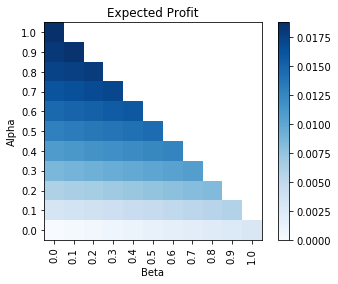

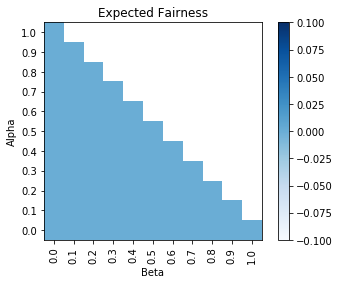

In [325]:
plot_heatmaps([expected_profit_map], x_labels=[str("{:.1f}".format(x)) for x in betas], 
              y_labels=[str("{:.1f}".format(x)) for x in alphas[::-1]], x_title='Beta', y_title='Alpha', 
              subplot_titles=['Expected Profit (Real-world)'], subfolder='plots', filename='heatmap_expected_profit_quota_2')
plot_heatmaps([expected_fairness_map], x_labels=[str("{:.1f}".format(x)) for x in betas], 
              y_labels=[str("{:.1f}".format(x)) for x in alphas[::-1]], x_title='Beta', y_title='Alpha', 
              subplot_titles=['Expected Fairness (Real-world)'], subfolder='plots', filename='heatmap_expected_fairness_quota_2')

## Calculates Expectations, not too sure if it's an entirely correct represenatation of NAdap since it isn't taking into account driver availability

In [553]:
expected_fairness_map_nadap, expected_profit_map_nadap = np.full((len(alphas), len(betas)), np.nan), \
                                                            np.full((len(alphas), len(betas)), np.nan)
for alpha_i in range(len(alphas)):
    for beta_j in range(len(betas)):
        if alphas[alpha_i] + betas[beta_j] <= 1:
            parameters_expected_measures = []
            for r in requests:
                parameters_expected_measures.append([r, x_f, x_fair, alphas[alpha_i], betas[beta_j]])
            with Pool(multiprocessing.cpu_count()) as p:
                results_fairness = p.starmap(measure_expected_fairness, parameters_expected_measures)
            with Pool(multiprocessing.cpu_count()) as p:
                results_profit = p.starmap(measure_expected_profit, parameters_expected_measures)
            expected_fairness_map_nadap[alpha_i, beta_j] = np.min(results_fairness)
            expected_profit_map_nadap[alpha_i, beta_j] = np.sum(results_profit)

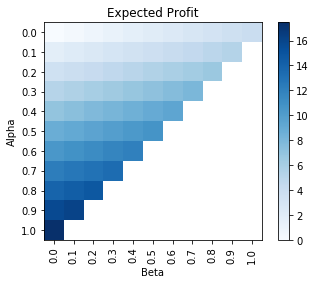

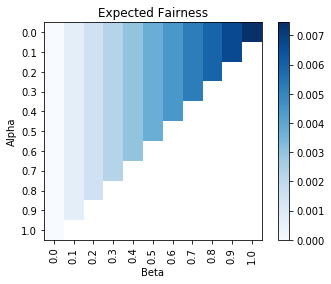

In [554]:
plot_heatmaps([expected_profit_map_nadap], x_labels=[str("{:.1f}".format(x)) for x in betas], 
              y_labels=[str("{:.1f}".format(x)) for x in alphas], x_title='Beta', y_title='Alpha', 
              subplot_titles=['Expected Profit'], subfolder='plots', filename='heatmap_expected_profit')
plot_heatmaps([expected_fairness_map_nadap], x_labels=[str("{:.1f}".format(x)) for x in betas], 
              y_labels=[str("{:.1f}".format(x)) for x in alphas], x_title='Beta', y_title='Alpha', 
              subplot_titles=['Expected Fairness'], subfolder='plots', filename='heatmap_expected_fairness')

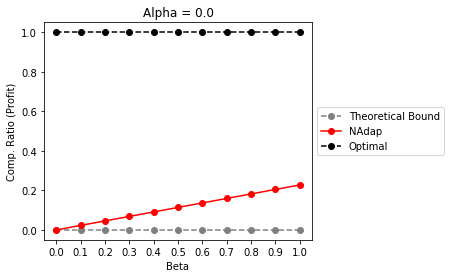

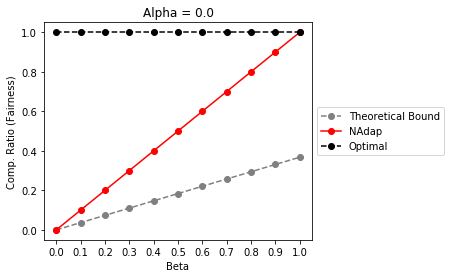

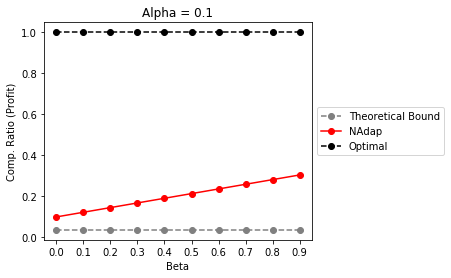

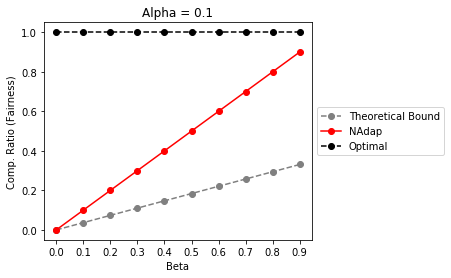

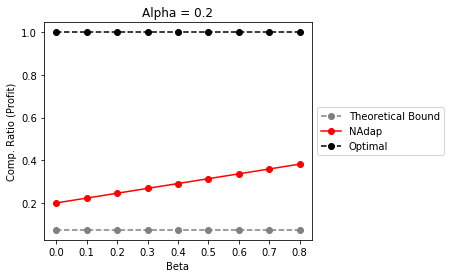

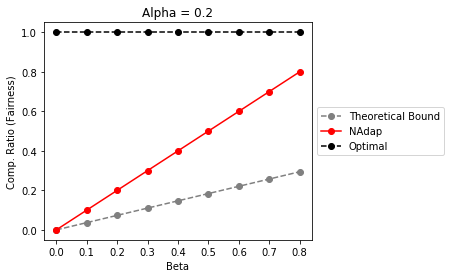

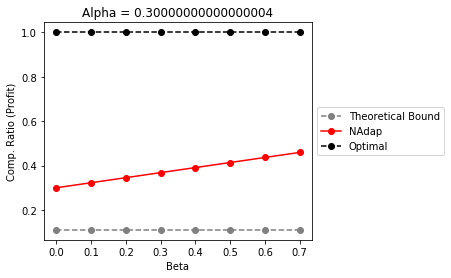

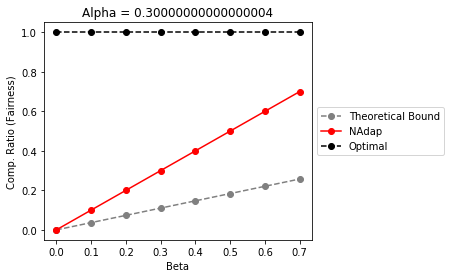

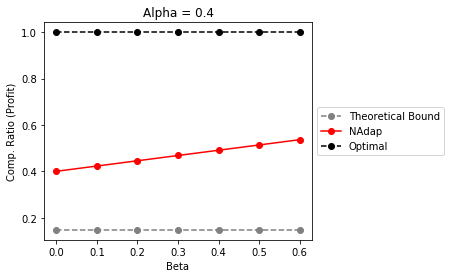

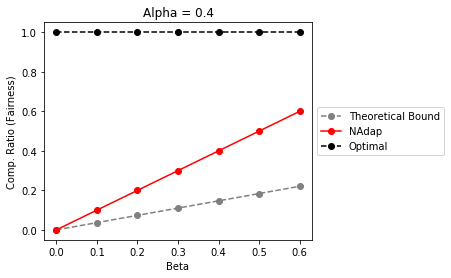

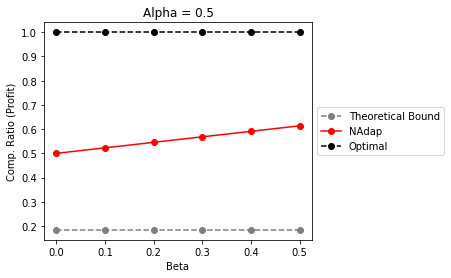

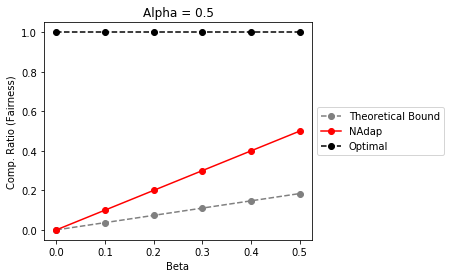

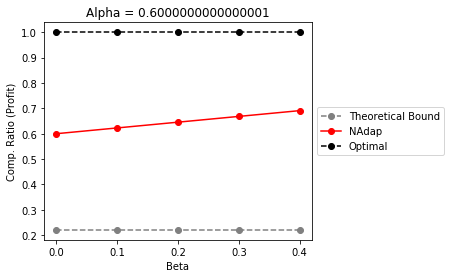

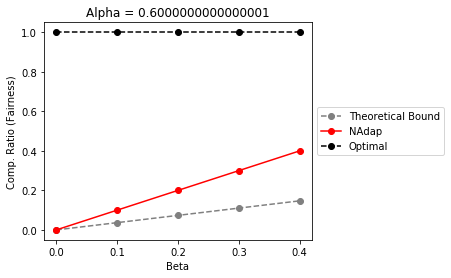

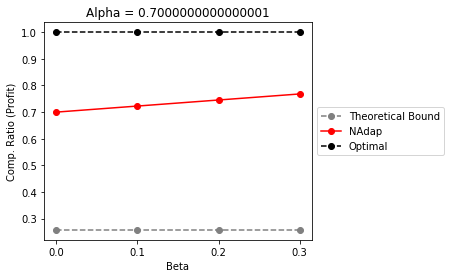

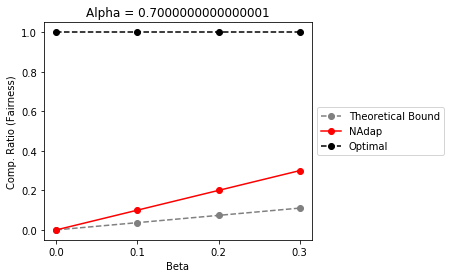

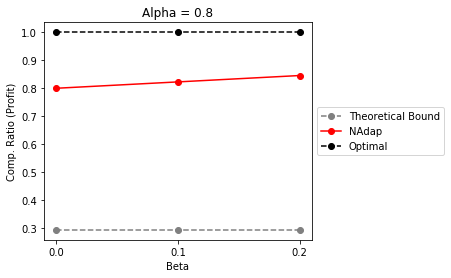

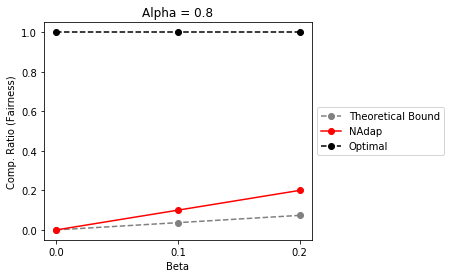

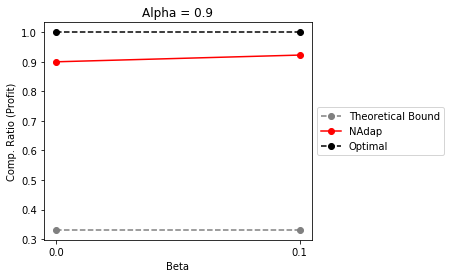

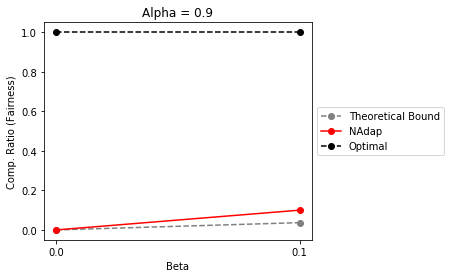

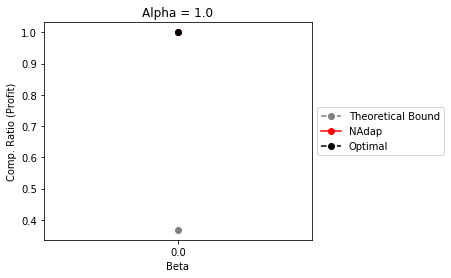

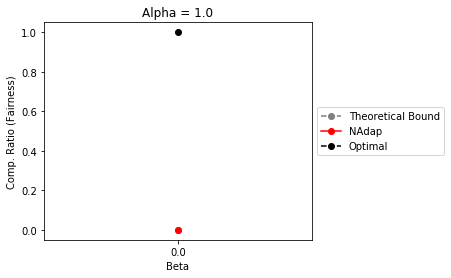

In [555]:
for alpha_i in range(len(alphas)):
    x_vals, profit_vals_nadap, fairness_vals_nadap = [], [], []
    profit_vals_theory, fairness_vals_theory = [], []
    for beta_j in range(len(betas)):
        if alphas[alpha_i] + betas[beta_j] <= 1:
            profit_vals_nadap.append(expected_profit_map_nadap[alpha_i, beta_j]/optimal_profit)
            fairness_vals_nadap.append(expected_fairness_map_nadap[alpha_i, beta_j]/optimal_fairness)
            x_vals.append(betas[beta_j])
            profit_vals_theory.append(alphas[alpha_i]/np.e)
            fairness_vals_theory.append(betas[beta_j]/np.e)
    profit_vals_optimal = [1] * len(x_vals)
    fairness_vals_optimal = [1] * len(x_vals)
    plot_lines([profit_vals_theory, profit_vals_nadap, profit_vals_optimal], ["{:.1f}".format(x) for x in x_vals], 
               x_vals, 'Alpha = {}'.format(alphas[alpha_i]), 'Beta', 'Comp. Ratio (Profit)', ['--', '-', '--'], 
               ['grey', 'red', 'black'], ['Theoretical Bound', 'NAdap', 'Optimal'], 'plots', 
               'expected_profit_beta_line_plot_{:.1f}'.format(alphas[alpha_i]))
    plot_lines([fairness_vals_theory, fairness_vals_nadap, fairness_vals_optimal], 
               ["{:.1f}".format(x) for x in x_vals], x_vals, 'Alpha = {}'.format(alphas[alpha_i]), 
               'Beta', 'Comp. Ratio (Fairness)', ['--', '-', '--'], ['grey', 'red', 'black'], 
               ['Theoretical Bound', 'NAdap', 'Optimal'], 'plots', 
               'expected_fairness_beta_line_plot_{:.1f}'.format(alphas[alpha_i]))

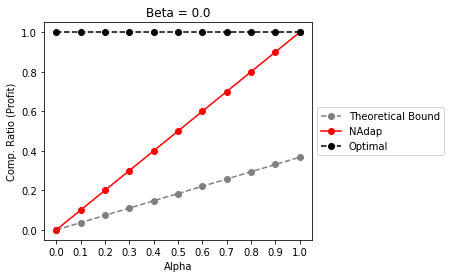

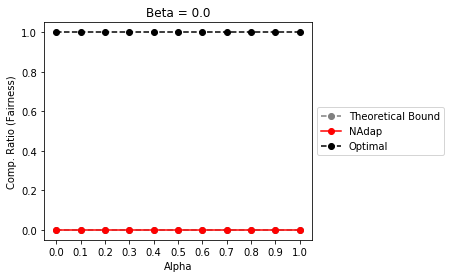

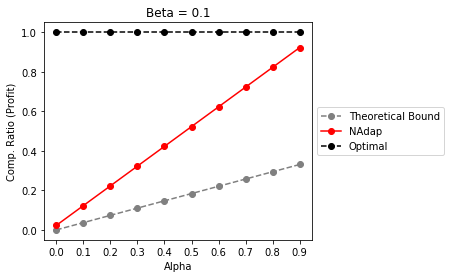

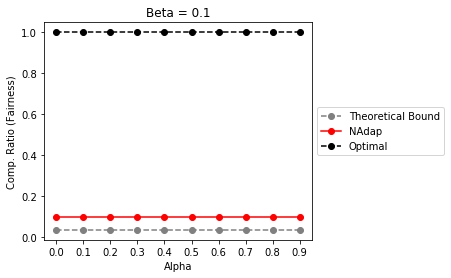

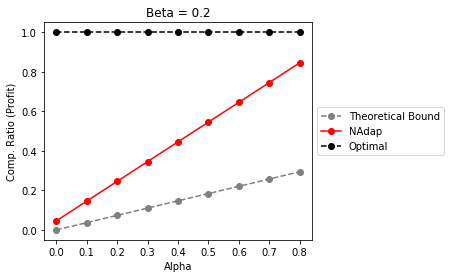

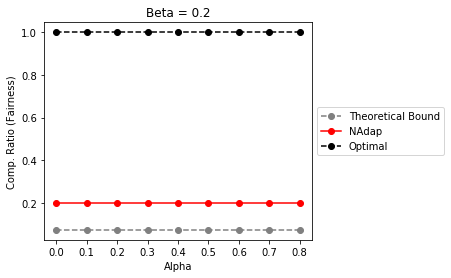

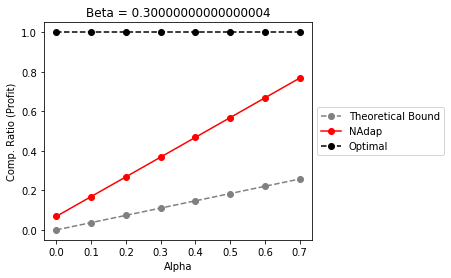

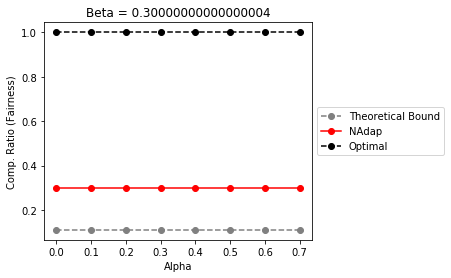

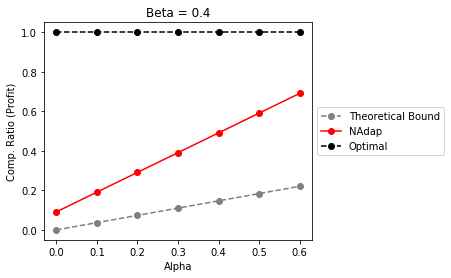

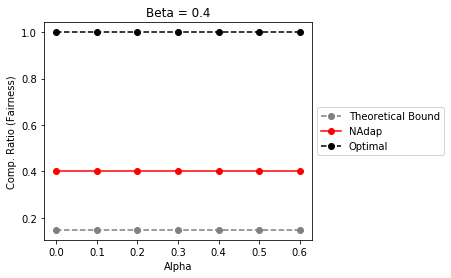

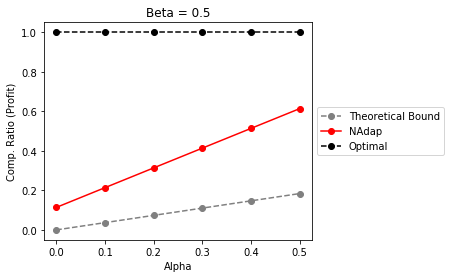

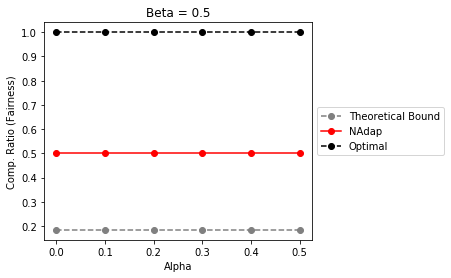

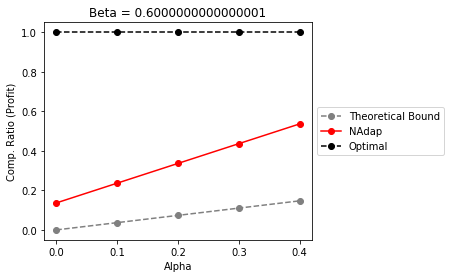

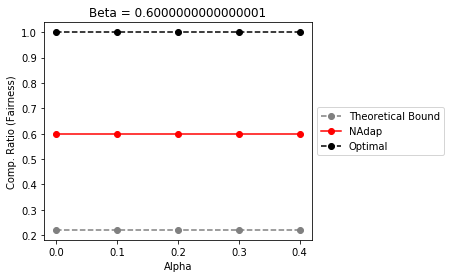

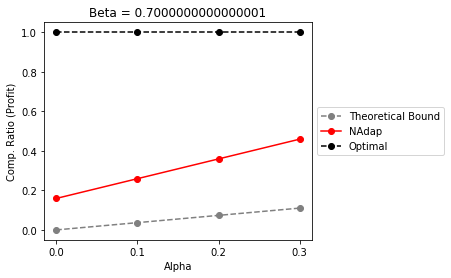

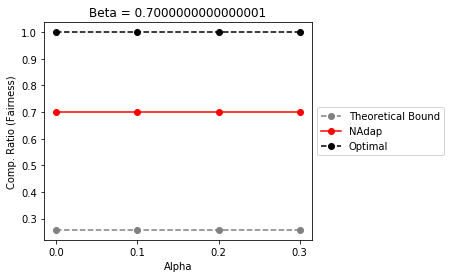

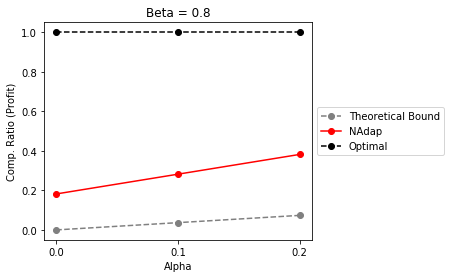

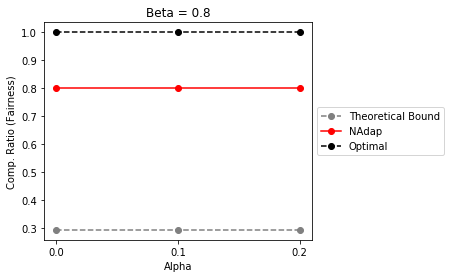

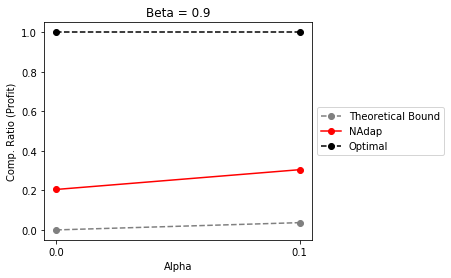

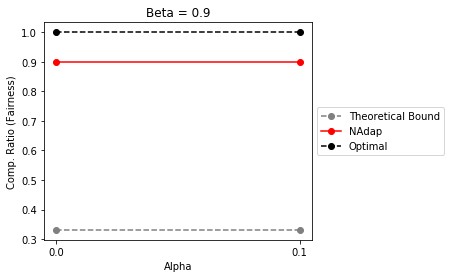

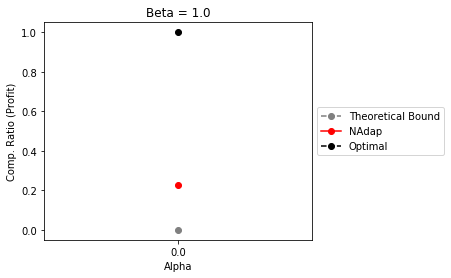

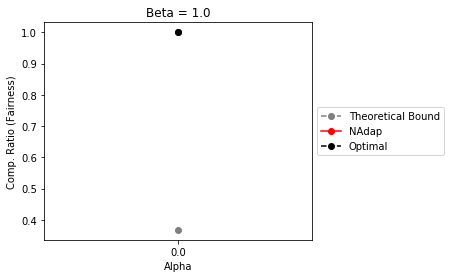

In [557]:
for beta_j in range(len(betas)):
    x_vals, profit_vals_nadap, fairness_vals_nadap = [], [], []
    profit_vals_theory, fairness_vals_theory = [], []
    for alpha_i in range(len(alphas)):
        if alphas[alpha_i] + betas[beta_j] <= 1:
            profit_vals_nadap.append(expected_profit_map_nadap[alpha_i, beta_j]/optimal_profit)
            fairness_vals_nadap.append(expected_fairness_map_nadap[alpha_i, beta_j]/optimal_fairness)
            x_vals.append(alphas[alpha_i])
            profit_vals_theory.append(alphas[alpha_i]/np.e)
            fairness_vals_theory.append(betas[beta_j]/np.e)
    profit_vals_optimal = [1] * len(x_vals)
    fairness_vals_optimal = [1] * len(x_vals)
    plot_lines([profit_vals_theory, profit_vals_nadap, profit_vals_optimal], ["{:.1f}".format(x) for x in x_vals], 
               x_vals, 'Beta = {}'.format(betas[beta_j]), 'Alpha', 'Comp. Ratio (Profit)', ['--', '-', '--'], 
               ['grey', 'red', 'black'], ['Theoretical Bound', 'NAdap', 'Optimal'], 'plots', 
               'expected_profit_alpha_line_plot_{:.1f}'.format(betas[beta_j]))
    plot_lines([fairness_vals_theory, fairness_vals_nadap, fairness_vals_optimal], 
               ["{:.1f}".format(x) for x in x_vals], x_vals, 'Beta = {}'.format(betas[beta_j]), 
               'Alpha', 'Comp. Ratio (Fairness)', ['--', '-', '--'], ['grey', 'red', 'black'], 
               ['Theoretical Bound', 'NAdap', 'Optimal'], 'plots', 
               'expected_fairness_alpha_line_plot_{:.1f}'.format(betas[beta_j]))

In [450]:
fairness_map, profit_map = np.full((len(alphas), len(betas)), np.nan), np.full((len(alphas), len(betas)), np.nan)
parameters = []
for alpha_i in range(len(alphas)):
    for beta_j in range(len(betas)):
        if alphas[alpha_i] + betas[beta_j] <= 1:
            drivers_copy = [copy.deepcopy(d) for d in drivers] # to avoid overwriting driver values here
            parameters.append([all_requests, drivers_copy, alphas[alpha_i], betas[beta_j]])
print (parameters)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
with Pool(multiprocessing.cpu_count()) as p:
    results = p.starmap(run_algorithm, parameters)

In [466]:
for i in range(len(results)):
    exact_profit, count, matches = results[i]
    exact_fairness = measure_exact_fairness(all_requests, matches)
    fairness_map[list(alphas).index(parameters[i][2])][list(betas).index(parameters[i][3])] = exact_fairness
    profit_map[list(alphas).index(parameters[i][2])][list(betas).index(parameters[i][3])] = exact_profit

Gender: f, Race: black, Start Lat bin: 7, Start Long bin: 19, End Lat bin: 5, End Long bin: 24
Gender: f, Race: black, Start Lat bin: 7, Start Long bin: 19, End Lat bin: 5, End Long bin: 24
Gender: f, Race: black, Start Lat bin: 7, Start Long bin: 19, End Lat bin: 5, End Long bin: 24
Gender: f, Race: black, Start Lat bin: 7, Start Long bin: 19, End Lat bin: 5, End Long bin: 24
Gender: f, Race: black, Start Lat bin: 7, Start Long bin: 19, End Lat bin: 5, End Long bin: 24
Gender: f, Race: black, Start Lat bin: 7, Start Long bin: 19, End Lat bin: 5, End Long bin: 24
Gender: f, Race: black, Start Lat bin: 7, Start Long bin: 19, End Lat bin: 5, End Long bin: 24
Gender: f, Race: black, Start Lat bin: 7, Start Long bin: 19, End Lat bin: 5, End Long bin: 24
Gender: f, Race: black, Start Lat bin: 7, Start Long bin: 19, End Lat bin: 5, End Long bin: 24
Gender: f, Race: black, Start Lat bin: 7, Start Long bin: 19, End Lat bin: 5, End Long bin: 24
Gender: f, Race: black, Start Lat bin: 7, Start Lo

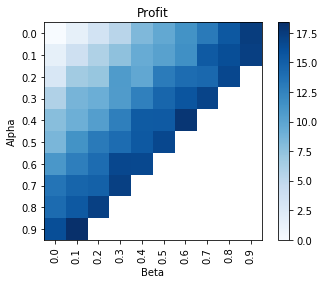

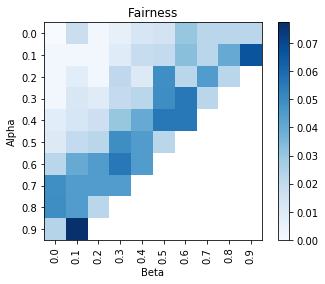

In [468]:
plot_heatmaps([profit_map], x_labels=[str("{:.1f}".format(x)) for x in betas], 
              y_labels=[str("{:.1f}".format(x)) for x in alphas], x_title='Beta', y_title='Alpha', 
              subplot_titles=['Profit'], subfolder='plots', filename='heatmap_profit')
plot_heatmaps([fairness_map], x_labels=[str("{:.1f}".format(x)) for x in betas], 
              y_labels=[str("{:.1f}".format(x)) for x in alphas], x_title='Beta', y_title='Alpha', 
              subplot_titles=['Fairness'], subfolder='plots', filename='heatmap_fairness')

0.0 0.0 0
0.0 0.1 1
0.0 0.2 2
0.0 0.30000000000000004 3
0.0 0.4 4
0.0 0.5 5
0.0 0.6000000000000001 6
0.0 0.7000000000000001 7
0.0 0.8 8
0.0 0.9 9


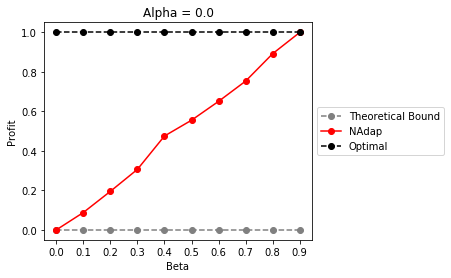

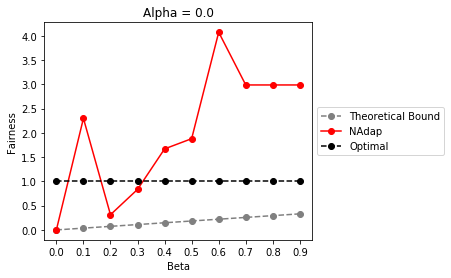

0.1 0.0 10
0.1 0.1 11
0.1 0.2 12
0.1 0.30000000000000004 13
0.1 0.4 14
0.1 0.5 15
0.1 0.6000000000000001 16
0.1 0.7000000000000001 17
0.1 0.8 18
0.1 0.9 19


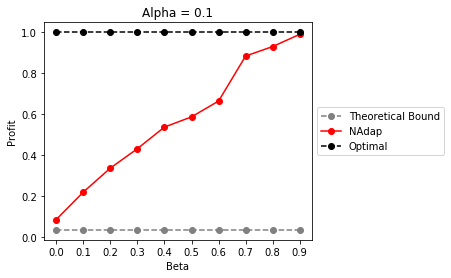

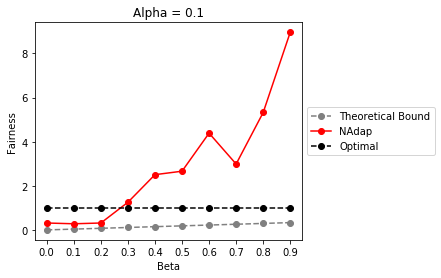

0.2 0.0 20
0.2 0.1 21
0.2 0.2 22
0.2 0.30000000000000004 23
0.2 0.4 24
0.2 0.5 25
0.2 0.6000000000000001 26
0.2 0.7000000000000001 27
0.2 0.8 28


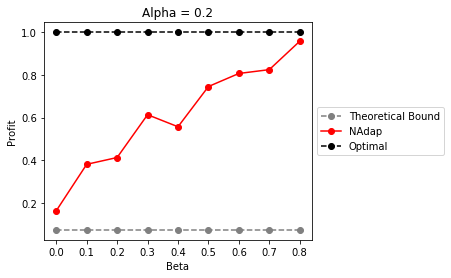

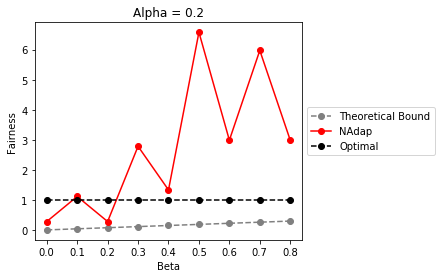

0.30000000000000004 0.0 29
0.30000000000000004 0.1 30
0.30000000000000004 0.2 31
0.30000000000000004 0.30000000000000004 32
0.30000000000000004 0.4 33
0.30000000000000004 0.5 34
0.30000000000000004 0.6000000000000001 35
0.30000000000000004 0.7000000000000001 36


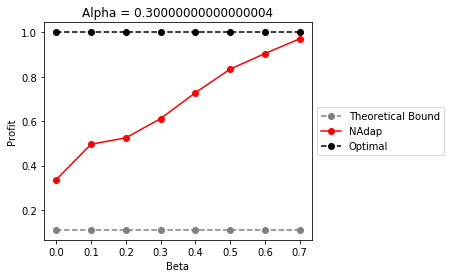

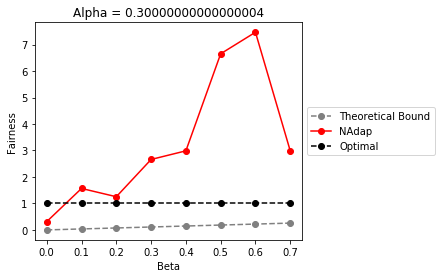

0.4 0.0 37
0.4 0.1 38
0.4 0.2 39
0.4 0.30000000000000004 40
0.4 0.4 41
0.4 0.5 42
0.4 0.6000000000000001 43


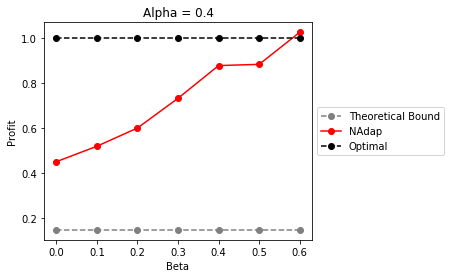

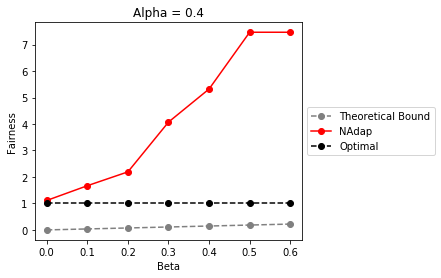

0.5 0.0 44
0.5 0.1 45
0.5 0.2 46
0.5 0.30000000000000004 47
0.5 0.4 48
0.5 0.5 49


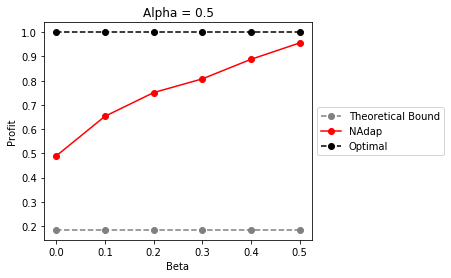

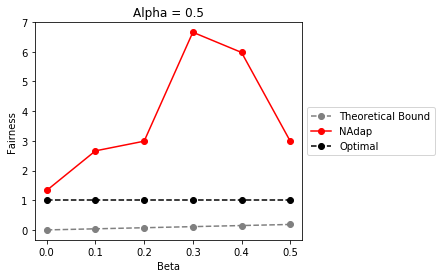

0.6000000000000001 0.0 50
0.6000000000000001 0.1 51
0.6000000000000001 0.2 52
0.6000000000000001 0.30000000000000004 53
0.6000000000000001 0.4 54


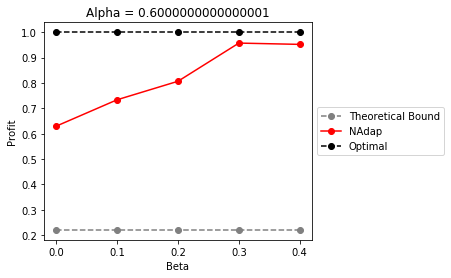

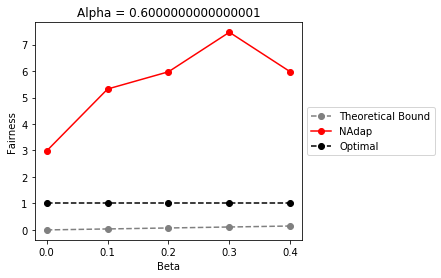

0.7000000000000001 0.0 55
0.7000000000000001 0.1 56
0.7000000000000001 0.2 57
0.7000000000000001 0.30000000000000004 58


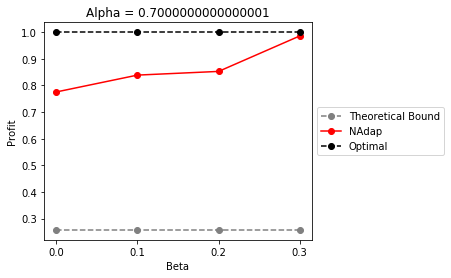

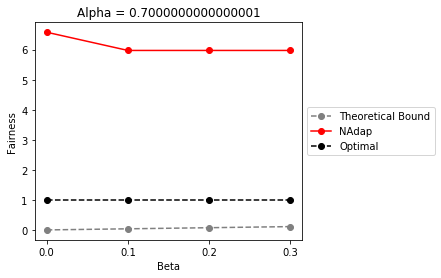

0.8 0.0 59
0.8 0.1 60
0.8 0.2 61


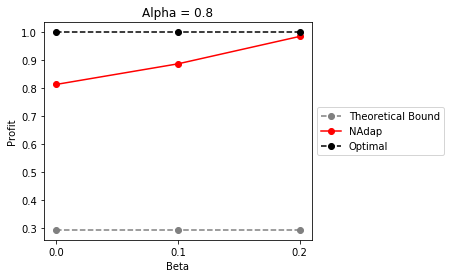

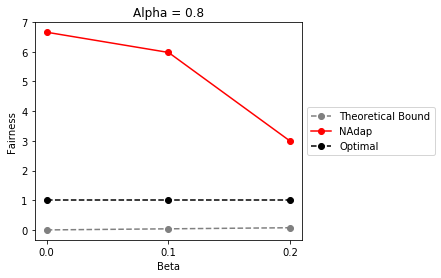

0.9 0.0 62
0.9 0.1 63


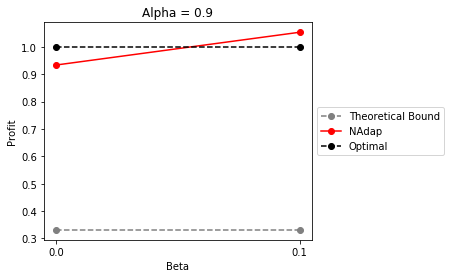

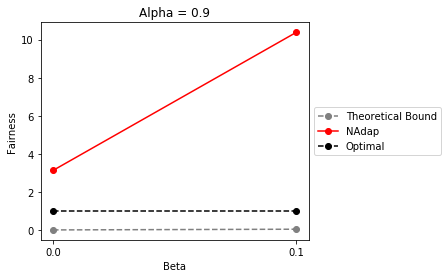

In [492]:
index = 0
for alpha_i in range(len(alphas)):
    x_vals, profit_vals_nadap, fairness_vals_nadap = [], [], []
    profit_vals_theory, fairness_vals_theory = [], []
    for beta_j in range(len(betas)):
        if alphas[alpha_i] + betas[beta_j] <= 1:
            print (alphas[alpha_i], betas[beta_j], index)
            exact_profit, _, matches = results[index]
            exact_fairness = measure_exact_fairness(all_requests, matches)
            profit_vals_nadap.append(exact_profit/optimal_profit)
            fairness_vals_nadap.append(exact_fairness/optimal_fairness)
            x_vals.append(betas[beta_j])
            profit_vals_theory.append(alphas[alpha_i]/np.e)
            fairness_vals_theory.append(betas[beta_j]/np.e)
            index += 1
    profit_vals_optimal = [1] * len(x_vals)
    fairness_vals_optimal = [1] * len(x_vals)
    plot_lines([profit_vals_theory, profit_vals_nadap, profit_vals_optimal], ["{:.1f}".format(x) for x in x_vals], 
               x_vals, 'Alpha = {}'.format(alphas[alpha_i]), 'Beta', 'Comp. Ratio (Profit)', ['--', '-', '--'], 
               ['grey', 'red', 'black'], ['Theoretical Bound', 'NAdap', 'Optimal'], 'plots', 
               'profit_beta_line_plot_{:.1f}'.format(alphas[alpha_i]))
    plot_lines([fairness_vals_theory, fairness_vals_nadap, fairness_vals_optimal], 
               ["{:.1f}".format(x) for x in x_vals], x_vals, 'Alpha = {}'.format(alphas[alpha_i]), 
               'Beta', 'Comp. Ratio (Fairness)', ['--', '-', '--'], ['grey', 'red', 'black'], 
               ['Theoretical Bound', 'NAdap', 'Optimal'], 'plots', 
               'fairness_beta_line_plot_{:.1f}'.format(alphas[alpha_i]))

0.0 0.0 0
0.1 0.0 1
0.2 0.0 2
0.30000000000000004 0.0 3
0.4 0.0 4
0.5 0.0 5
0.6000000000000001 0.0 6
0.7000000000000001 0.0 7
0.8 0.0 8
0.9 0.0 9
[0.0, 0.036787944117144235, 0.07357588823428847, 0.11036383235143273, 0.14715177646857694, 0.18393972058572117, 0.22072766470286545, 0.2575156088200097, 0.2943035529371539, 0.33109149705429813]


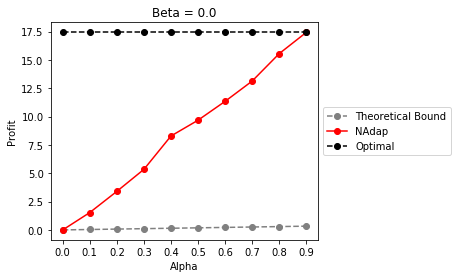

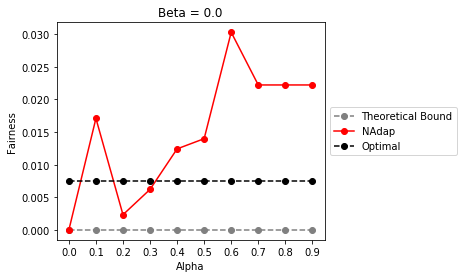

0.0 0.1 10
0.1 0.1 11
0.2 0.1 12
0.30000000000000004 0.1 13
0.4 0.1 14
0.5 0.1 15
0.6000000000000001 0.1 16
0.7000000000000001 0.1 17
0.8 0.1 18
0.9 0.1 19
[0.0, 0.036787944117144235, 0.07357588823428847, 0.11036383235143273, 0.14715177646857694, 0.18393972058572117, 0.22072766470286545, 0.2575156088200097, 0.2943035529371539, 0.33109149705429813]


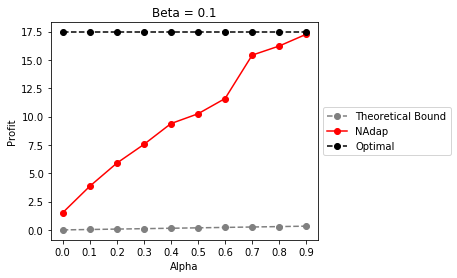

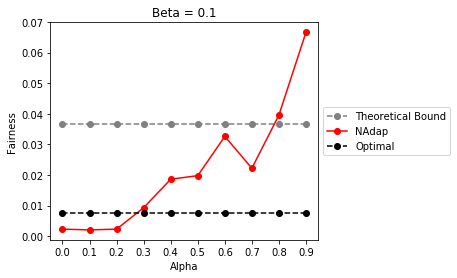

0.0 0.2 20
0.1 0.2 21
0.2 0.2 22
0.30000000000000004 0.2 23
0.4 0.2 24
0.5 0.2 25
0.6000000000000001 0.2 26
0.7000000000000001 0.2 27
0.8 0.2 28
[0.0, 0.036787944117144235, 0.07357588823428847, 0.11036383235143273, 0.14715177646857694, 0.18393972058572117, 0.22072766470286545, 0.2575156088200097, 0.2943035529371539]


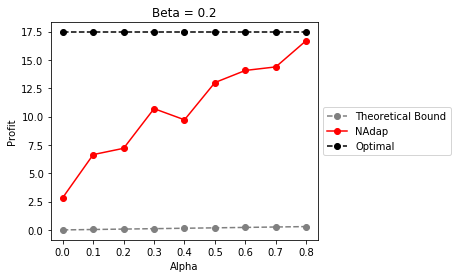

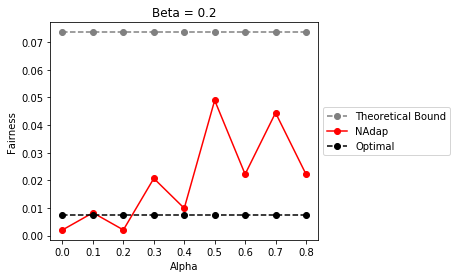

0.0 0.30000000000000004 29
0.1 0.30000000000000004 30
0.2 0.30000000000000004 31
0.30000000000000004 0.30000000000000004 32
0.4 0.30000000000000004 33
0.5 0.30000000000000004 34
0.6000000000000001 0.30000000000000004 35
0.7000000000000001 0.30000000000000004 36
[0.0, 0.036787944117144235, 0.07357588823428847, 0.11036383235143273, 0.14715177646857694, 0.18393972058572117, 0.22072766470286545, 0.2575156088200097]


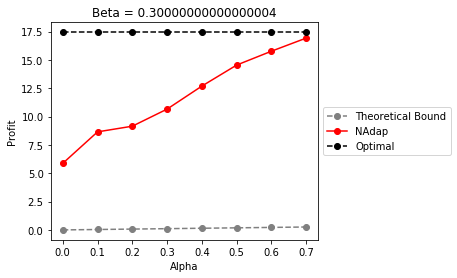

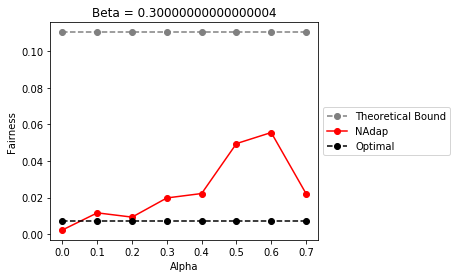

0.0 0.4 37
0.1 0.4 38
0.2 0.4 39
0.30000000000000004 0.4 40
0.4 0.4 41
0.5 0.4 42
0.6000000000000001 0.4 43
[0.0, 0.036787944117144235, 0.07357588823428847, 0.11036383235143273, 0.14715177646857694, 0.18393972058572117, 0.22072766470286545]


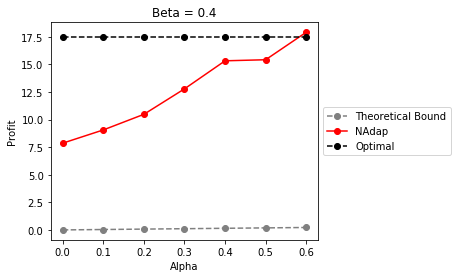

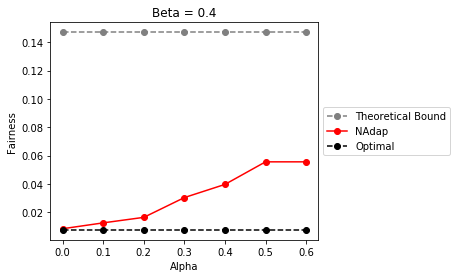

0.0 0.5 44
0.1 0.5 45
0.2 0.5 46
0.30000000000000004 0.5 47
0.4 0.5 48
0.5 0.5 49
[0.0, 0.036787944117144235, 0.07357588823428847, 0.11036383235143273, 0.14715177646857694, 0.18393972058572117]


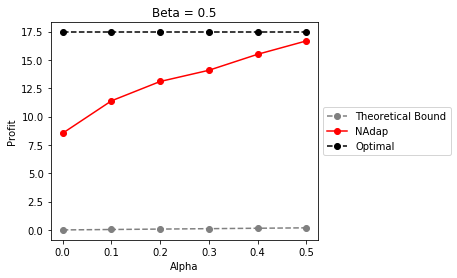

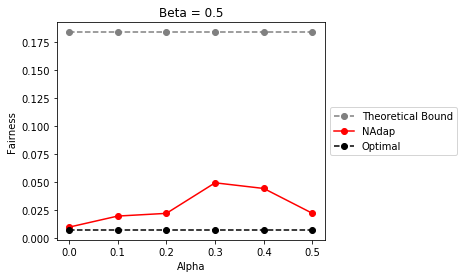

0.0 0.6000000000000001 50
0.1 0.6000000000000001 51
0.2 0.6000000000000001 52
0.30000000000000004 0.6000000000000001 53
0.4 0.6000000000000001 54
[0.0, 0.036787944117144235, 0.07357588823428847, 0.11036383235143273, 0.14715177646857694]


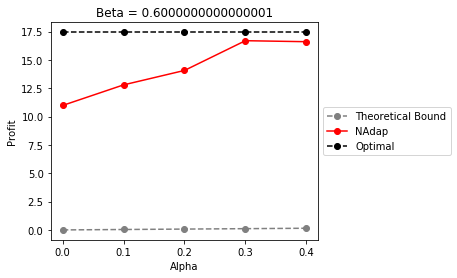

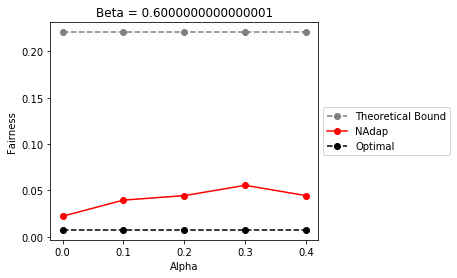

0.0 0.7000000000000001 55
0.1 0.7000000000000001 56
0.2 0.7000000000000001 57
0.30000000000000004 0.7000000000000001 58
[0.0, 0.036787944117144235, 0.07357588823428847, 0.11036383235143273]


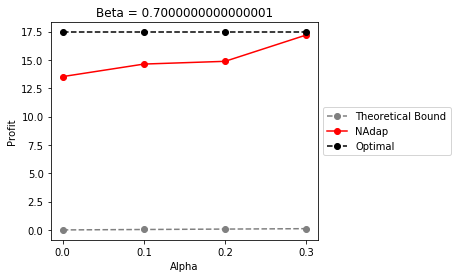

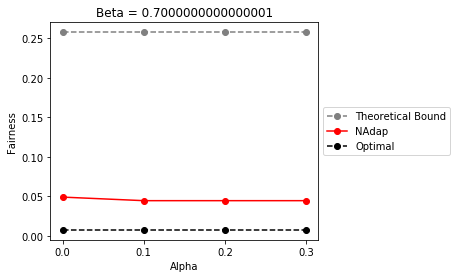

0.0 0.8 59
0.1 0.8 60
0.2 0.8 61
[0.0, 0.036787944117144235, 0.07357588823428847]


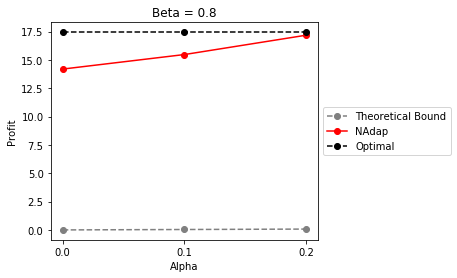

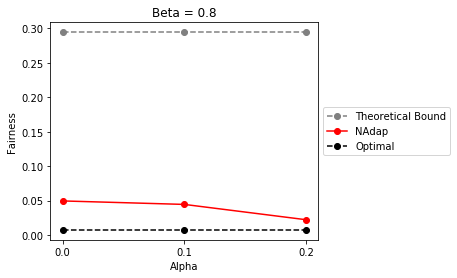

0.0 0.9 62
0.1 0.9 63
[0.0, 0.036787944117144235]


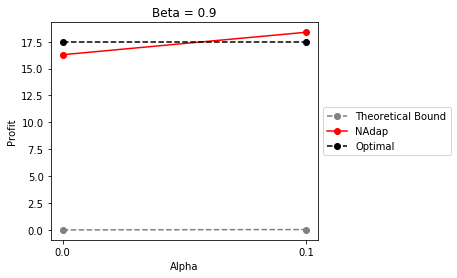

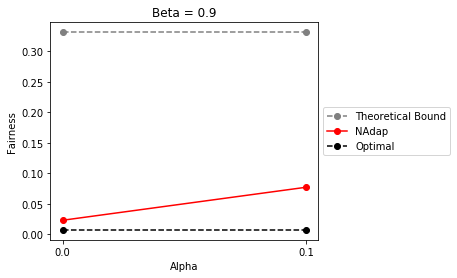

In [491]:
index = 0
for beta_j in range(len(betas)):
    x_vals, profit_vals_nadap, fairness_vals_nadap = [], [], []
    profit_vals_theory, fairness_vals_theory = [], []
    for alpha_i in range(len(alphas)):
        if alphas[alpha_i] + betas[beta_j] <= 1:
            print (alphas[alpha_i], betas[beta_j], index)
            exact_profit, _, matches = results[index]
            exact_fairness = measure_exact_fairness(all_requests, matches)
            profit_vals_nadap.append(exact_profit/optimal_profit)
            fairness_vals_nadap.append(exact_fairness/optimal_fairness)
            x_vals.append(alphas[alpha_i])
            profit_vals_theory.append(alphas[alpha_i]/np.e)
            fairness_vals_theory.append(betas[beta_j]/np.e)
            index += 1
    print (profit_vals_theory)
    profit_vals_optimal = [1] * len(x_vals)
    fairness_vals_optimal = [1] * len(x_vals)
    plot_lines([profit_vals_theory, profit_vals_nadap, profit_vals_optimal], ["{:.1f}".format(x) for x in x_vals], 
               x_vals, 'Beta = {}'.format(betas[beta_j]), 'Alpha', 'Comp. Ratio (Profit)', ['--', '-', '--'], 
               ['grey', 'red', 'black'], ['Theoretical Bound', 'NAdap', 'Optimal'], 'plots', 
               'profit_alpha_line_plot_{:.1f}'.format(betas[beta_j]))
    plot_lines([fairness_vals_theory, fairness_vals_nadap, fairness_vals_optimal], 
               ["{:.1f}".format(x) for x in x_vals], x_vals, 'Beta = {}'.format(betas[beta_j]), 
               'Alpha', 'Comp. Ratio (Fairness)', ['--', '-', '--'], ['grey', 'red', 'black'], 
               ['Theoretical Bound', 'NAdap', 'Optimal'], 'plots', 
               'fairness_alpha_line_plot_{:.1f}'.format(betas[beta_j]))